## Helio Inaba - CQF June 2023 Final Project 
## Optimal Hedging with Advanced Delta Modelling

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import norm
from scipy.optimize import minimize


from datetime import datetime
import os

#pd.set_option('display.max_columns', None)
pd.reset_option('^display.', silent=True)


#### Defining Functions

In [2]:
def gaussian(data, bins):
    
    return 1/(data.std()*np.sqrt(2*np.pi))*(np.exp(-(bins - data.mean())**2/(2*data.std()**2)))


def black_scholes(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d1 = norm.cdf(d1)
    n_d2 = norm.cdf(d2)

    V = n_d1*S-n_d2*K*np.exp(-r*T)
    
    return V


def bs_delta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    n_d1 = norm.cdf(d1)
    
    return n_d1


def bs_gamma(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))


def bs_vega(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return S*norm.pdf(d1)*np.sqrt(T)


def bs_theta(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))
    theta -= r*K*np.exp(-r*T)*n_d2

    return theta

def bs_rho(S, K, sigma, T, r):

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    return K*T*np.exp(-r*T)*n_d2


def euler_maruyama(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_periods, n_simulations))
    prices[0] = s0

    for i in range(1, n_periods):

        prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*np.random.normal(loc=0.0, scale=1.0, size=n_simulations))

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def antithetic_variables(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    prices_plus = np.zeros((n_simulations, n_periods+1))
    prices_plus[:,0] = s0

    prices_minus = np.zeros((n_simulations, n_periods+1))
    prices_minus[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))
    z_minus = -z

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    wiener_matrix_minus = np.matmul(A_matrix, z_minus)
    wiener_matrix_minus = np.transpose(wiener_matrix_minus)

    prices_plus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)
    prices_minus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix_minus)

    prices_plus = pd.DataFrame(np.transpose(prices_plus))
    prices_minus = pd.DataFrame(np.transpose(prices_minus))
    
    prices_plus.index.name = 'period'
    prices_plus.index.columns = 'simulation'

    prices_minus.index.name = 'period'
    prices_minus.index.columns = 'simulation'

    return prices_plus, prices_minus


def fill_bridge_array(a, b, delta_t, z=None):
    
    if type(z) == type(None):
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z

def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    n = int(np.log2(n_periods))

    compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

    W_t = np.empty((n_periods+1, n_simulations))
    W_t[:] = np.nan
    W_t[0] = 0.0

    prices = np.zeros((n_periods+1, n_simulations))
    prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
    prices.iloc[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    k = 0
    W_t[-1,:] = norm_sample[k,:]

    df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
            k+=1
            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
            
    prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
    prices.index = prices.index*expiry_T

    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def fill_bridge(a, b, delta_t, z=None):

    
    if z == None:
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):

    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt


def call_price(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_milstein(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path =  milstein(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_anti(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_plus, prices_minus = antithetic_variables(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = .5*(np.maximum(prices_plus.iloc[-1]-strike_E,0)+np.maximum(prices_minus.iloc[-1]-strike_E,0))
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_sobol(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    prices_path = sobol_prices(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)

    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            payoff*np.exp(-risk_free*(expiry_T))]

### Part I: Volatility Arb with improved GBM and Monte-Carlo ###

1. Consider improvements to GBM asset evolution (Euler-Maruyana/Milstein schemes). <br> Optionally, can consider modelling asset with jumps, eg, Merton jump diffusion, without going into stochastic volatility, eg Heston-Nandi. <br> Variance Gamma is also relevant but suited for single-name assets with extreme movements.
 - consider MC variance reduction techniques, such as antithetic variates; <br>
 - best practice is low discrepancy sequences, eg Sobol with the Brownian bridge.


#### Defining Constants

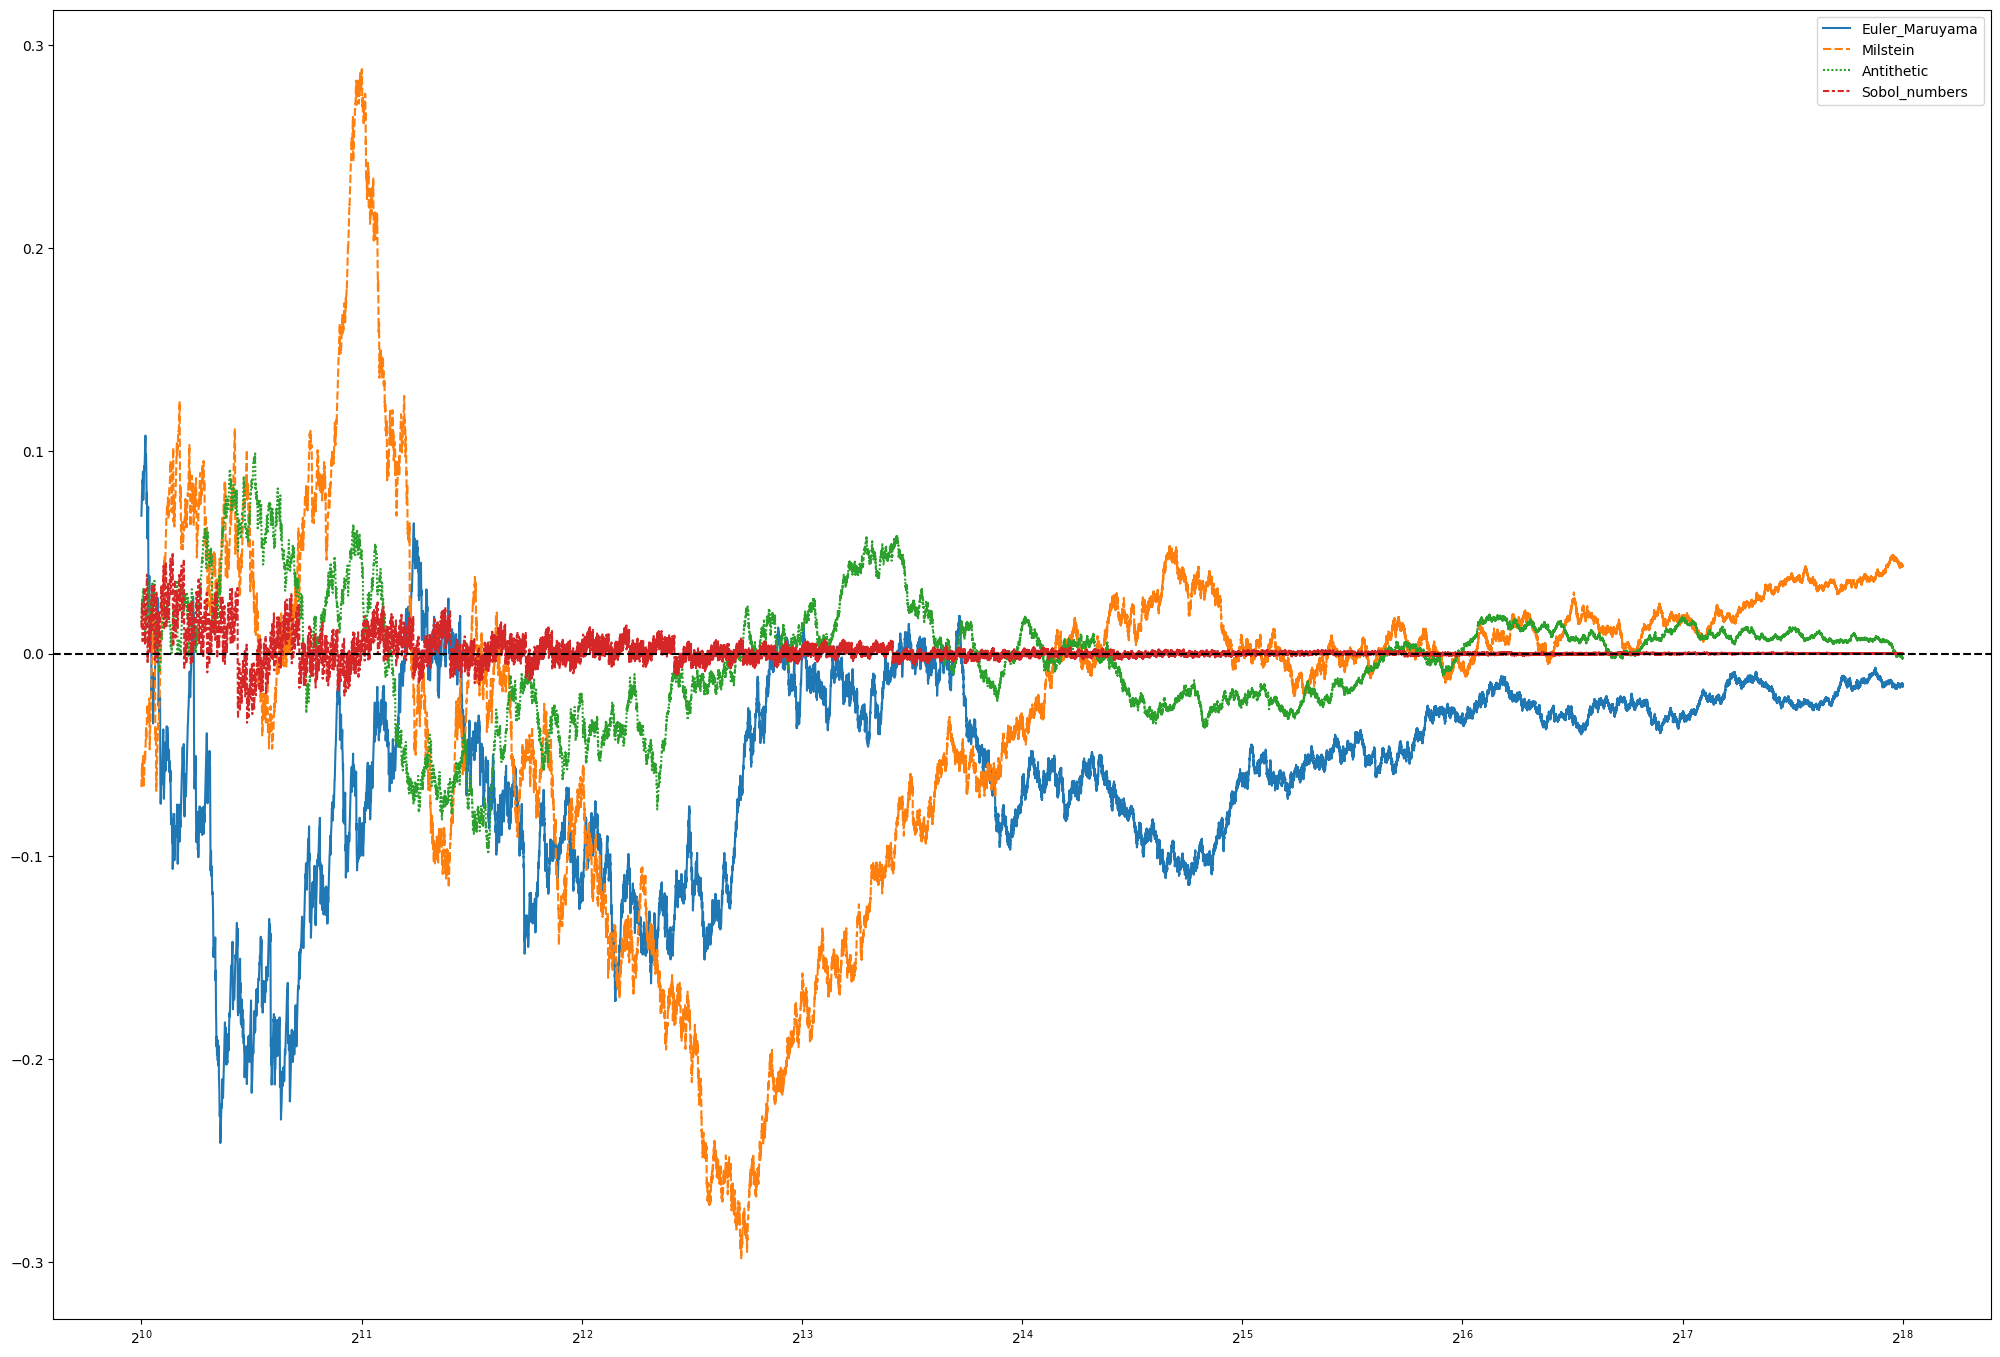

Euler_Maruyama   -0.016243
Milstein          0.042164
Antithetic       -0.002314
Sobol_numbers     0.000046
Name: 262143, dtype: float64


In [3]:
S = 50
K = 55
sigma = .30
r = .1
T = 360/360

bs_price = black_scholes(S, K, sigma, T, r)

df_mc_errors = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_numbers'])

n_simulations = 2**18
n_periods = 2**9

df_mc_errors['Euler_Maruyama'] = bs_price - pd.Series(call_price(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['Milstein'] = bs_price - pd.Series(call_price_milstein(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['Antithetic'] = bs_price - pd.Series(call_price_anti(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1]).expanding().mean()
df_mc_errors['Sobol_numbers'] = bs_price - call_price_sobol(s0=S, strike_E=K, expiry_T=T, sigma=sigma, risk_free=r, n_periods=n_periods, n_simulations=int(n_simulations))[1].expanding().mean()

fig, ax = plt.subplots(figsize=(25, 17))

sns.lineplot(df_mc_errors.loc[1024:], 
             ax=ax)

plt.axhline(y=0.0, color='black', linestyle='--')

ax.set_xscale('log', base=2)
plt.show()

print(df_mc_errors.iloc[-1])


2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is
the impact of time-dependent Gamma $ \Gamma_{t} $? What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

In [ ]:
# def euler_maruyama_brownian_bridge(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

#     n = int(np.log2(n_periods))
#     prices = np.zeros((n_simulations, n_periods))
#     prices[0] = s0

#     for i in range(1, n_simulations):

#         prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*brownian_bridge(w0=0, w1=0.0, n=n).W_t.diff().iloc[1:].values)

#     prices = pd.DataFrame(prices)
#     prices.index.name = 'period'
#     prices.index.columns = 'simulation'
#     prices = prices

#     return prices

In [ ]:
data = sobol_prices(s0=S, expiry_T=1, sigma=sigma, return_rate=r, n_periods=2**9, n_simulations=2**16).iloc[-1]



In [ ]:
n = 2**19
r = 0.1
sigma = .3

data = milstein(s0=S, expiry_T=1, sigma=sigma, return_rate=r, n_periods=1, n_simulations=n).iloc[-1]

fx = [np.exp(-(x**2)/2)/np.sqrt(2*np.pi) for x in np.linspace(-3,3,n)]

x_lognorm = S*np.exp(r-(sigma*sigma)/2)*np.exp(np.linspace(-3,3,n)*sigma)
y_lognorm = fx
y_lognorm = y_lognorm/sum(np.diff(x_lognorm)*y_lognorm[1:])

fig, ax = plt.subplots()
sns.histplot(data,
             stat='density',
             bins=1000,
             ax=ax)

sns.lineplot(ax=ax,
             x=x_lognorm,
             y=y_lognorm,
             color='red')

2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

In [4]:
def delta_hedged_ptf(stock_path, K, T, sigma, r):

    df_hedged_ptf = pd.DataFrame(columns=['Cash_Position', 'Cash_Rebalance', 'Daily_Interest', '#_Stocks', 'Ptf_Stock', 'Ptf_Total'],
                                 index=range(0,len(stock_path)))
    
    
    s0 = stock_path[0]
    n_periods = len(stock_path)
    
    df_hedged_ptf['Cash_Position'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Cash_Rebalance'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Daily_Interest'] = [0.0]*len(df_hedged_ptf)

    df_hedged_ptf['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_hedged_ptf.index, stock_path)]
    df_hedged_ptf.loc[0, 'Cash_Position'] = -df_hedged_ptf.loc[0, '#_Stocks']*s0

    df_hedged_ptf['Ptf_Stock'] = df_hedged_ptf['#_Stocks']*stock_path
    df_hedged_ptf['Cash_Rebalance'] = -df_hedged_ptf['#_Stocks'].diff().fillna(0)*stock_path

    for i in df_hedged_ptf.index[1:]:

        df_hedged_ptf.loc[i, 'Daily_Interest'] = df_hedged_ptf.loc[i-1, 'Cash_Position']*r*T/n_periods
        df_hedged_ptf.loc[i, 'Cash_Position'] = df_hedged_ptf.loc[i-1, 'Cash_Position'] + df_hedged_ptf.loc[i, 'Cash_Rebalance'] + df_hedged_ptf.loc[i, 'Daily_Interest']

    df_hedged_ptf['Ptf_Total'] = df_hedged_ptf['Cash_Position'] + df_hedged_ptf['Ptf_Stock']

    return df_hedged_ptf


def call_ptf(stock_path, K, T,sigma, r):

    s0 = stock_path[0]
    n_periods = len(stock_path)

    V_i = black_scholes(S=s0, K=K, sigma=sigma, T=T, r=r)

    df_call_ptf = pd.DataFrame(columns=['Call_Price', 'Call_Carry', 'Call_PnL'],
                               index=range(0,len(stock_path)))

    df_call_ptf['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Carry'] = [V_i*(1-np.exp(r*T*t/n_periods)) for t in df_call_ptf.index]
    df_call_ptf['Call_PnL'] = df_call_ptf['Call_Price'] - df_call_ptf.loc[0,'Call_Price'] + df_call_ptf['Call_Carry']
    
    df_call_ptf['Call_Delta'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Gamma'] = [bs_gamma(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Theta'] = [bs_theta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    
    df_call_ptf['Call_Rho'] = [bs_rho(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Vega'] = [bs_vega(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]

    df_call_ptf['PnL_Delta'] = (df_call_ptf['Call_Delta'].shift(1)*stock_path.diff()).cumsum()
    df_call_ptf['PnL_Gamma'] = (df_call_ptf['Call_Gamma'].shift(1)*np.square(stock_path.diff())).cumsum()/2
    df_call_ptf['PnL_Theta'] = (df_call_ptf['Call_Theta'].shift(1)*T/n_periods).cumsum()
    df_call_ptf['PnL_Carry'] = df_call_ptf['Call_Carry']

    df_call_ptf['PnL_Greeks'] = df_call_ptf[['PnL_Delta','PnL_Gamma','PnL_Theta','PnL_Carry']].sum(axis=1)

    return df_call_ptf

    

In [5]:
S = 50
K = 55
sigma_i = .30
sigma_a = .40

r = .1
T = 1 #in years

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

print(V_a-V_i)

1.9594215755698023


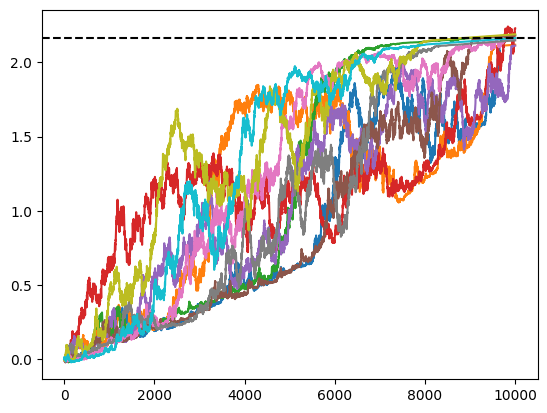

In [6]:
T = 1.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


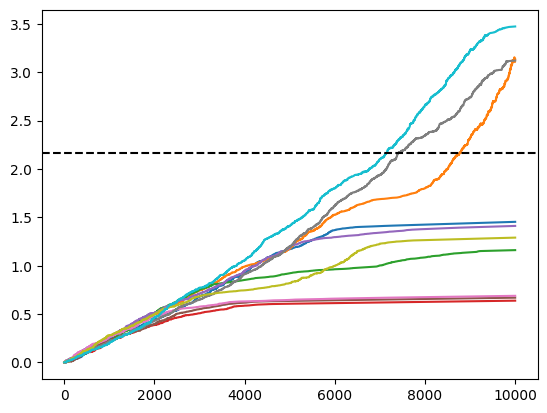

In [7]:
T = 1.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_i, r=r).Ptf_Total

    plt.plot(df_call - df_ptf)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')


In [ ]:
# n_periods = 2**15
# T = 1

# path_foo = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=1).iloc[:,0]
# path_foo = path_foo.to_frame(name='Stock_Price')

# #path_foo = path_foo.to_frame(name='Stock_Price')

# path_foo['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo['Call_Delta_i'] = [bs_delta(S=s, K=K, sigma=sigma_i, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo['Call_Delta_a'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]

# path_foo['Call_Carry'] = [-V_i*r*t*T/n_periods for t in path_foo.index]
# path_foo['Call_PnL'] = path_foo['Call_Price'] - path_foo.loc[0,'Call_Price'] + path_foo['Call_Carry']

# path_foo['Cash_Position'] = [0.0]*len(path_foo)
# path_foo['Cash_Rebalance'] = [0.0]*len(path_foo)
# path_foo['Daily_Interest'] = [0.0]*len(path_foo)

# path_foo['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma_a, T=T*(1-t/n_periods), r=r) for t,s in zip(path_foo.index, path_foo.Stock_Price)]
# path_foo.loc[0, 'Cash_Position'] = -path_foo.loc[0, 'Call_Delta_a']*path_foo.loc[0, 'Stock_Price']

# path_foo['Ptf_Stock'] = path_foo['#_Stocks']*path_foo['Stock_Price']
# path_foo['Cash_Rebalance'] = -path_foo['#_Stocks'].diff().fillna(0)*path_foo['Stock_Price']

# for i in path_foo.index[1:]:

#     path_foo.loc[i, 'Daily_Interest'] = path_foo.loc[i-1, 'Cash_Position']*r*T/n_periods
#     path_foo.loc[i, 'Cash_Position'] = path_foo.loc[i-1, 'Cash_Position'] + path_foo.loc[i, 'Cash_Rebalance'] + path_foo.loc[i, 'Daily_Interest']

# path_foo['Ptf_Total'] = path_foo['Cash_Position'] + path_foo['Ptf_Stock']

# plt.plot(path_foo['Call_PnL'] - path_foo['Ptf_Total'])

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is\
the impact of time-dependent Gamma $ \Gamma_{t} $? <br> What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

#### $Total P\&L \approx \sum_{t}^{T} \frac{1}{2} \Gamma_{t} S^{2}_{t}\left [ r^2_{t} -\sigma_{t,imp}^2 \Delta t\right ] $

In [ ]:
stock_path = df_price_paths.loc[:, i]

df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r)
df_ptf = -delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r)

df_total = df_call.merge(df_ptf, right_index=True, left_index=True)

df_total['PnL_Total'] = df_total[['Call_PnL','Ptf_Total']].sum(axis=1)
df_total['PnL_Delta_Total'] = df_total.PnL_Delta + df_total.Ptf_Stock.diff(1).cumsum() + df_total.Cash_Rebalance.cumsum()
df_total['Total_Carry'] = df_total['PnL_Carry'] + df_total['Daily_Interest'].cumsum()


df_total[['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']].plot()

for col in ['PnL_Total','PnL_Gamma','PnL_Delta_Total','PnL_Theta','Total_Carry']:
    
    plt.annotate('%.2f' % df_total[col].iloc[-1], xy=(n_periods, df_total[col].iloc[-1]))

plt.show()

## Part II: Minimum Variance Delta

1. begin with sorting your IV data – or each trading day, you will need BS option price as
implied vol percentage, delta, and vega: ($ V_{t} $,$ \delta_{bs} $,$ \nu_{bs} $). <br> 
The term structure for option expiry $ 1M, 3M, 6M, 9M, 12M $, weekly expiries not necessary. <br> 
Key choice to make here, if
you are going to study Delta for out of the money call strikes, in addition to about ATM
buckets $ 0.45 < \delta_{bs} <0.55 $ – each strike means a separate a,b,c history for each expiry.

In [8]:
dict_dtpyes = {'[QUOTE_UNIXTIME]': int,
               ' [QUOTE_READTIME]' : object,
               ' [QUOTE_DATE]': str,
               ' [QUOTE_TIME_HOURS]': float, 
               ' [UNDERLYING_LAST]': float,
               ' [EXPIRE_DATE]': object,
               ' [EXPIRE_UNIX]': int,
               ' [DTE]': float,
               ' [C_DELTA]': object,
               ' [C_GAMMA]': object, 
               ' [C_VEGA]': object,
               ' [C_THETA]': object, 
               ' [C_RHO]': object, 
               ' [C_IV]': object, 
               ' [C_VOLUME]':object, 
               ' [C_LAST]': object,
               ' [C_SIZE]': object,
               ' [C_BID]': object, 
               ' [C_ASK]':object, 
               ' [STRIKE]': object, 
               ' [P_BID]':object,
               ' [P_ASK]':object,  
               ' [P_SIZE]':object, 
               ' [P_LAST]':object,
               ' [P_DELTA]': object,
               ' [P_GAMMA]': object,
               ' [P_VEGA]': object, 
               ' [P_THETA]': object, 
               ' [P_RHO]':object,
               ' [P_IV]':object,
               ' [P_VOLUME]': object,
               ' [STRIKE_DISTANCE]': float,
               ' [STRIKE_DISTANCE_PCT]': float}

csv_files = sorted(os.listdir('spx_eod_data'))

df_option_data = pd.DataFrame()

for file in csv_files:

    df_option_data = pd.concat([df_option_data,
                                pd.read_csv(filepath_or_buffer=f'spx_eod_data/{file}', 
                                            dtype=dict_dtpyes)
                                ])

# df_option_data = pd.read_csv(filepath_or_buffer='spx_eod_data/spx_eod_201001.txt')

#Parse Data
df_option_data.columns = [x.strip().replace('[','').replace(']','') for x in df_option_data.columns]
df_option_data['QUOTE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.QUOTE_DATE]
df_option_data['EXPIRE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.EXPIRE_DATE]

#df_option_data = df_option_data[[not((df_option_data.loc[x]==' ').any()) for x in df_option_data.index]]
df_option_data = df_option_data.replace(' ', np.nan)
df_option_data = df_option_data[~df_option_data.isna().any(axis=1)]
df_option_data = df_option_data.loc[df_option_data.DTE > 14]

for col in ['C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 'C_BID', 'C_ASK',
            'STRIKE', 'P_BID', 'P_ASK', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 
            'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT']:
    
    df_option_data[col] = [float(x) for x in df_option_data[col]]

df_option_data['C_MID'] = (df_option_data['C_ASK']+df_option_data['C_BID'])/2
df_option_data['P_MID'] = (df_option_data['P_ASK']+df_option_data['P_BID'])/2

df_option_data = df_option_data.reset_index(drop=True)

In [9]:
df_option_data['C_BS'] = [black_scholes(S=S,K=K,sigma=sigma,T=T/360,r=0) 
                          for S,K,sigma,T in zip(df_option_data['UNDERLYING_LAST'],
                                                 df_option_data['STRIKE'],
                                                 df_option_data['C_IV'], 
                                                 df_option_data['DTE'])]

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_85178/1444163933.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))


2. compute your dependent variable and run the fitting on $ \delta_{bs} $,$ \delta^2_{bs} $. <br>Dependent side based
on daily option price changes $ \Delta V_{t} $, and you will need $( \Delta S_{t} , S_{t}) $ as well as Greeks noted
above. <br> The exact data columns will depend on how you organise regression or do SLSQP.

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_option_data.QUOTE_DATE.min(), end=df_option_data.QUOTE_DATE.max())

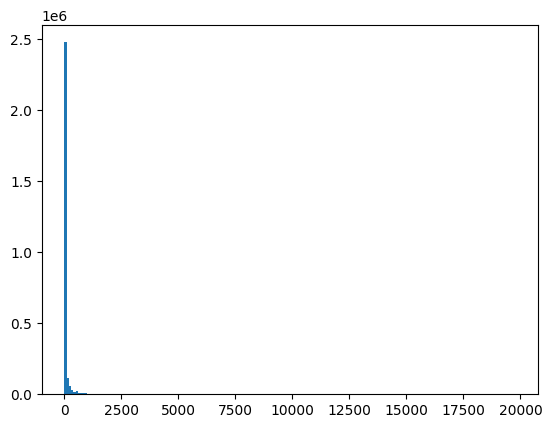

In [151]:
plt.hist(df_option_data.loc[:,'C_VOLUME'],bins=200)
plt.show()

In [167]:
df_option_data

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,C_MID,P_MID,C_BS
0,1262638800,2010-01-04 16:00,2010-01-04,16.0,1132.99,2010-02-18,1266526800,45.0,0.95684,0.00089,0.31769,-0.06932,0.24238,0.25501,0.0,121.90,103 x 103,152.10,154.70,980.0,3.00,3.60,252 x 252,3.40,-0.06598,0.00116,0.51419,-0.15762,-0.09838,0.27473,264.0,153.0,0.135,153.400,3.300,155.150237
1,1262638800,2010-01-04 16:00,2010-01-04,16.0,1132.99,2010-02-18,1266526800,45.0,0.94098,0.00135,0.43201,-0.09116,0.40348,0.25067,0.0,128.90,103 x 103,137.80,140.41,995.0,3.99,4.41,5 x 252,4.30,-0.08261,0.00140,0.61131,-0.18234,-0.12271,0.26639,43.0,138.0,0.122,139.105,4.200,140.970455
2,1262638800,2010-01-04 16:00,2010-01-04,16.0,1132.99,2010-02-18,1266526800,45.0,0.92685,0.00161,0.52579,-0.10991,0.50134,0.24812,0.0,117.00,103 x 204,128.29,131.21,1005.0,4.20,5.00,252 x 252,4.65,-0.09179,0.00158,0.66345,-0.19142,-0.13683,0.25688,121.0,128.0,0.113,129.750,4.600,131.681329
3,1262638800,2010-01-04 16:00,2010-01-04,16.0,1132.99,2010-02-18,1266526800,45.0,0.92137,0.00167,0.56304,-0.11627,0.53459,0.24458,0.0,99.30,103 x 103,123.70,126.30,1010.0,4.50,5.30,252 x 252,4.90,-0.09845,0.00167,0.69621,-0.19842,-0.14625,0.25340,186.0,123.0,0.109,125.000,4.900,126.946887
4,1262638800,2010-01-04 16:00,2010-01-04,16.0,1132.99,2010-02-18,1266526800,45.0,0.90526,0.00204,0.65488,-0.13429,0.60363,0.24001,0.0,99.40,103 x 103,114.40,117.00,1020.0,5.10,6.09,201 x 252,5.85,-0.11213,0.00193,0.76658,-0.21333,-0.16732,0.24613,67.0,113.0,0.100,115.700,5.595,117.717949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757947,1672434000,2022-12-30 16:00,2022-12-30,16.0,3839.81,2027-12-17,1829077200,1813.0,0.59832,0.00019,29.30870,-0.25731,73.03152,0.23496,1.0,956.58,5 x 5,799.40,842.80,4100.0,580.30,593.80,5 x 5,597.79,-0.44269,0.00031,29.48942,-0.07216,-53.05330,0.19561,1.0,260.2,0.068,821.100,587.050,701.642660
2757948,1672434000,2022-12-30 16:00,2022-12-30,16.0,3839.81,2027-12-17,1829077200,1813.0,0.58086,0.00021,29.80751,-0.25836,72.14661,0.23160,1.0,755.00,5 x 5,754.60,796.90,4200.0,617.50,631.10,5 x 5,580.00,-0.48228,0.00040,29.21442,-0.06515,-52.82823,0.18797,0.0,360.2,0.094,775.750,624.300,656.081579
2757949,1672434000,2022-12-30 16:00,2022-12-30,16.0,3839.81,2027-12-17,1829077200,1813.0,0.54614,0.00017,30.62470,-0.25840,69.97318,0.22470,50.0,666.00,5 x 5,668.60,708.90,4400.0,695.80,709.40,5 x 5,659.10,-0.58567,0.00048,26.95929,-0.04809,-48.76327,0.17175,1.0,560.2,0.146,688.750,702.600,569.049721
2757950,1672434000,2022-12-30 16:00,2022-12-30,16.0,3839.81,2027-12-17,1829077200,1813.0,0.52902,0.00016,30.93223,-0.25839,68.65588,0.22203,1.0,784.63,5 x 5,640.20,657.50,4500.0,736.80,750.50,5 x 5,689.79,-0.66095,0.00060,24.00560,-0.03611,-42.94311,0.16070,1.0,660.2,0.172,648.850,743.650,530.586604


{'whiskers': [<matplotlib.lines.Line2D at 0x2a2d59d30>,
 'caps': [<matplotlib.lines.Line2D at 0x2a2d585c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a2d5a6f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a2d58fb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a2d5ba40>],
 'means': []}

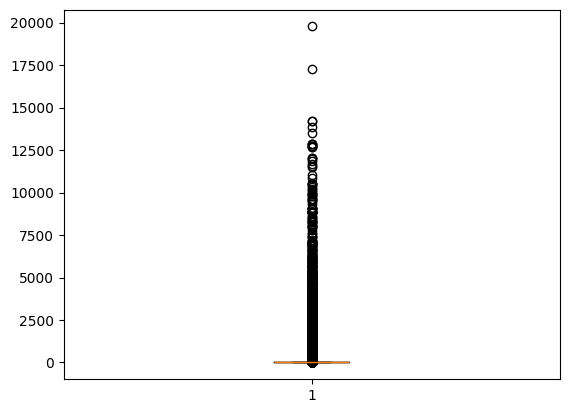

In [150]:
plt.boxplot(df_option_data.loc[:,'C_VOLUME'])

In [160]:
pd.set_option('display.max_columns', None)

In [176]:
df_calls_diff = df_calls_diff[df_calls_diff['C_LAST_t1']-df_calls_diff['C_LAST_t0'] != 0]

UNDERLYING_LAST_t1  DTE_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                               
2010-01-04    0.9             3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
              0.7             3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
...                                                         ...     ...   
2022-12-29    0.5             12M                       3848.66   722.0   
                              12M                       3848.66   722.0   
                              12M                       3848.66   722.0   
              0.4             12M                       3848.66   722.0   
                              12M                       3848.66   722.0   

                                             C_DELTA_t1  C_VEGA_t1  C_IV_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                   
2010-01-04    0.9             3M                0.92137    0.56304  0.24458   
                              3M                0.90526    0.65488  0.24001   
              0.7             3M                0.74893    1.27133  0.20731   
                              3M                0.73001    1.31920  0.20442   
                              3M                0.70983    1.36823  0.20162   
...                                                 ...        ...      ...   
2022-12-29    0.5             12M               0.51798   20.56214  0.24363   
                              12M               0.48807   20.66365  0.23704   
                              12M               0.45720   20.63773  0.23091   
              0.4             12M               0.42563   20.47217  0.22464   
                              12M               0.39408   20.16069  0.21919   

                                             C_LAST_t1  C_MID_t1     C_BS_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.9             3M                 99.30   125.000  126.946887   
                              3M                 99.40   115.700  117.717949   
              0.7             3M                 63.67    63.400   65.509333   
                              3M                 59.50    59.405   61.526854   
                              3M                 55.15    55.605   57.636464   
...                                                ...       ...         ...   
2022-12-29    0.5             12M               467.49   465.000  427.703255   
                              12M               391.00   415.550  378.632221   
                              12M               371.30   369.000  333.330339   
              0.4             12M               323.60   325.100  290.592761   
                              12M               283.11   284.500  252.489113   

                                             C_VOLUME_t1  UNDERLYING_LAST_t0  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.9             3M                     0.0             1136.40   
                              3M                     0.0             1136.40   
              0.7             3M                    10.0             1136.40   
                              3M                    14.0             1136.40   
                              3M                    19.0             1136.40   
...                                                  ...                 ...   
2022-12-29    0.5             12M                   75.0             3839.81   
                              12M                   30.0             3839.81   
                              12M                  125.0             3839.81   
              0.4             12M                    1.0             3839.81   
                              12M       

In [174]:
sum(df_calls_diff['C_LAST_t1']-df_calls_diff['C_LAST_t0'] == 0)/len(df_calls_diff)

0.6220215642550517

In [177]:
df_calls = df_option_data.set_index(['QUOTE_DATE','EXPIRE_UNIX','STRIKE'])[['UNDERLYING_LAST','DTE', 'C_DELTA', 'C_VEGA', 'C_IV', 'C_LAST','C_MID','C_BS','C_VOLUME']]
df_calls['QUOTE_DATE'] = df_calls.index.get_level_values(0)

df_calls = df_calls[(df_calls.C_DELTA < .95)&(df_calls.C_DELTA > .05)]
df_calls = df_calls[~df_calls.index.get_level_values(0).isin(holidays)].copy()

quote_dates = sorted(df_calls.index.get_level_values(0).unique())

df_calls_diff = df_calls.loc[quote_dates[0]].merge(
    df_calls.loc[quote_dates[1]], 
    left_index=True, 
    right_index=True, 
    suffixes=('_t1','_t0'), 
    how='inner')


for i in range(len(quote_dates[2:])):
    df_calls_diff = pd.concat([df_calls_diff,
                               df_calls.loc[quote_dates[i+1]].merge(
                                   df_calls.loc[quote_dates[i+2]], 
                                   left_index=True,
                                   right_index=True,
                                   suffixes=('_t1','_t0'),
                                   how='inner')],
                     axis=0)
    
df_calls_diff = df_calls_diff[df_calls_diff['C_LAST_t1']-df_calls_diff['C_LAST_t0'] != 0]
    
df_calls_diff['delta_price'] = df_calls_diff['C_LAST_t0'] - df_calls_diff['C_LAST_t1']
df_calls_diff['delta_S'] = df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['delta_price_perc'] = (df_calls_diff['C_LAST_t0'] - df_calls_diff['C_LAST_t1'])/df_calls_diff['C_LAST_t1']
df_calls_diff['delta_S_perc'] = (df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1'])/df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_diff.C_DELTA_t1]
df_calls_diff['Expiry_Bucket'] = pd.cut(df_calls_diff.DTE_t1,[14, 30, 91, 182, 365, df_calls_diff.DTE_t1.max()],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

df_calls_diff = df_calls_diff[abs(df_calls_diff.delta_S_perc) > 1e-4].copy()
df_calls_diff = df_calls_diff.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket','Expiry_Bucket'])

df_calls_diff['y'] = (df_calls_diff['delta_price']/df_calls_diff['delta_S']-df_calls_diff['C_DELTA_t1'])*df_calls_diff['UNDERLYING_LAST_t1']*np.sqrt(df_calls_diff['DTE_t1']/360)/(df_calls_diff['C_VEGA_t1']*100)

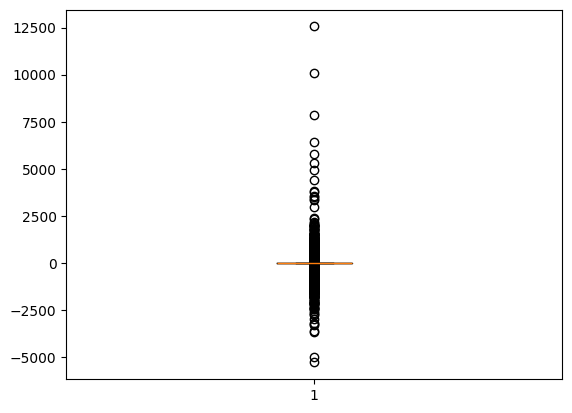

In [178]:
plt.boxplot(df_calls_diff['y'])
plt.show()

In [179]:

# Eliminate outlier on y
q75, q25 = np.percentile(df_calls_diff.y, [75,25])
intr_qr = q75-q25

cut_max = q75+(1.5*intr_qr)
cut_min = q25-(1.5*intr_qr)

df_calls_diff = df_calls_diff[(df_calls_diff['y'] > cut_min) & (df_calls_diff['y'] < cut_max)].copy()



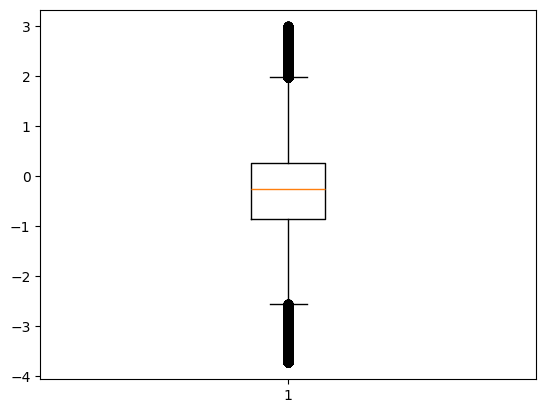

In [180]:
plt.boxplot(df_calls_diff['y'])
plt.show()

In [181]:
df_quote_dates = pd.Series(df_calls_diff.index.get_level_values(0).unique())

i = len(df_quote_dates)-21*36
testing_period = df_quote_dates.loc[i:i+21*36].values

In [182]:
import itertools

lists = [
   df_quote_dates.loc[21*36:].values,
   df_calls_diff.index.get_level_values(2).unique().categories
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[21*36:].values, df_quote_dates.loc[:].values)})

In [183]:
df_quote_dates[0]

Timestamp('2010-01-04 00:00:00')

In [184]:
def quadratic_fit(df_option_prices):

    df = df_option_prices.groupby(['Expiry_Bucket','BS_Delta_Bucket'],
                                  observed=True).y.mean()

    expiry_buckets  = df.index.get_level_values(0).unique()

    df_result = pd.DataFrame(index=expiry_buckets,columns=['a', 'b', 'c'])

    for expiry in expiry_buckets:

        c,b,a = np.polyfit(y=df.loc[expiry],
                           x=df.loc[expiry].index,
           deg=2)
        
        df_result.loc[expiry,['a', 'b', 'c']] = [a, b, c]

    return df_result


for i in range(0, len(df_quote_dates)-21*36):

    training_period = df_quote_dates.loc[i:i+21*36].values
    testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

    df_params.loc[training_period[-1], ['a', 'b', 'c']] = quadratic_fit(df_calls_diff.loc[training_period]).values

    print(training_period[-1])

2013-03-08T00:00:00.000000000
2013-03-11T00:00:00.000000000
2013-03-12T00:00:00.000000000
2013-03-13T00:00:00.000000000
2013-03-14T00:00:00.000000000
2013-03-15T00:00:00.000000000
2013-03-18T00:00:00.000000000
2013-03-19T00:00:00.000000000
2013-03-20T00:00:00.000000000
2013-03-21T00:00:00.000000000
2013-03-22T00:00:00.000000000
2013-03-25T00:00:00.000000000
2013-03-26T00:00:00.000000000
2013-03-27T00:00:00.000000000
2013-03-28T00:00:00.000000000
2013-04-01T00:00:00.000000000
2013-04-02T00:00:00.000000000
2013-04-03T00:00:00.000000000
2013-04-04T00:00:00.000000000
2013-04-05T00:00:00.000000000
2013-04-08T00:00:00.000000000
2013-04-09T00:00:00.000000000
2013-04-10T00:00:00.000000000
2013-04-11T00:00:00.000000000
2013-04-12T00:00:00.000000000
2013-04-15T00:00:00.000000000
2013-04-16T00:00:00.000000000
2013-04-17T00:00:00.000000000
2013-04-18T00:00:00.000000000
2013-04-19T00:00:00.000000000
2013-04-22T00:00:00.000000000
2013-04-23T00:00:00.000000000
2013-04-24T00:00:00.000000000
2013-04-25

In [185]:
df_params['minus_b'] = -df_params['b']

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_85178/4130161031.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


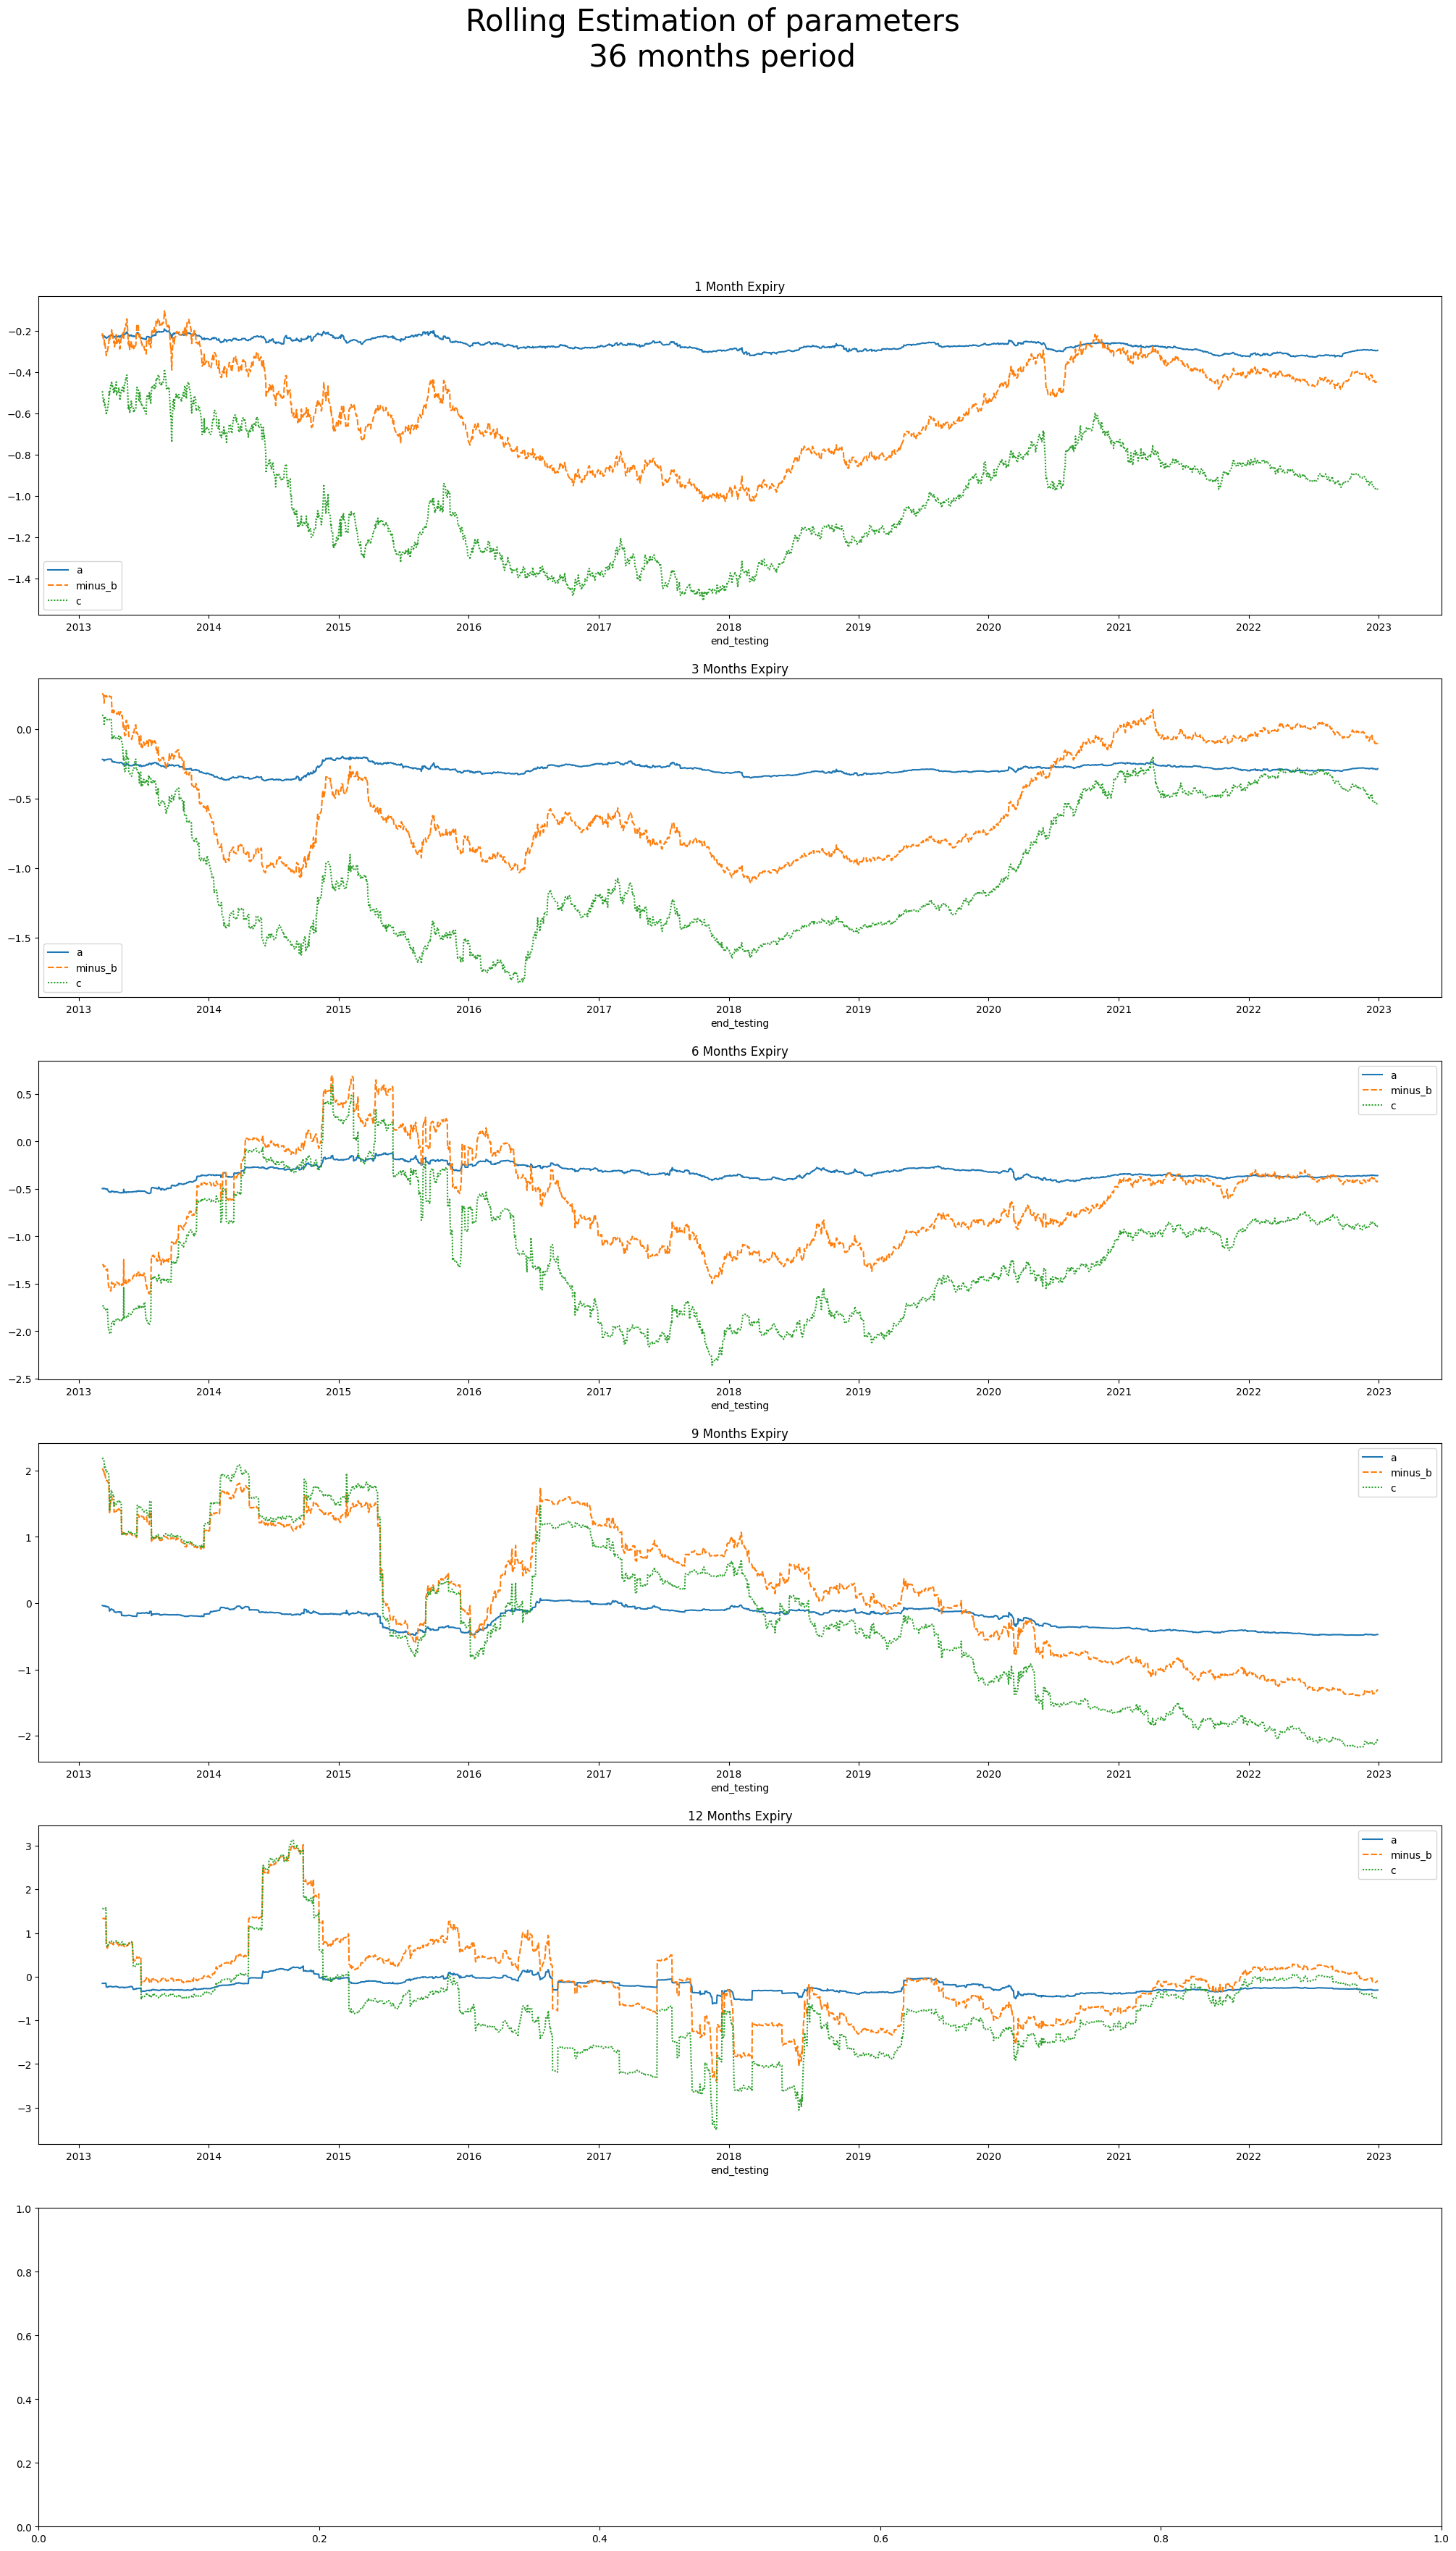

In [198]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(25,40))

fig.suptitle('Rolling Estimation of parameters \n 36 months period', 
             fontsize=30)


sns.lineplot(df_params.xs('1M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[0])
ax[0].set_title('1 Month Expiry')

sns.lineplot(df_params.xs('3M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[1])
ax[1].set_title('3 Months Expiry')

sns.lineplot(df_params.xs('6M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[2])
ax[2].set_title('6 Months Expiry')

sns.lineplot(df_params.xs('9M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[3])
ax[3].set_title('9 Months Expiry')

sns.lineplot(df_params.xs('12M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[4])
ax[4].set_title('12 Months Expiry')

fig.show()


In [ ]:
import timeit

In [200]:
df_option_data.columns

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'C_MID', 'P_MID',
       'C_BS'],
      dtype='object')

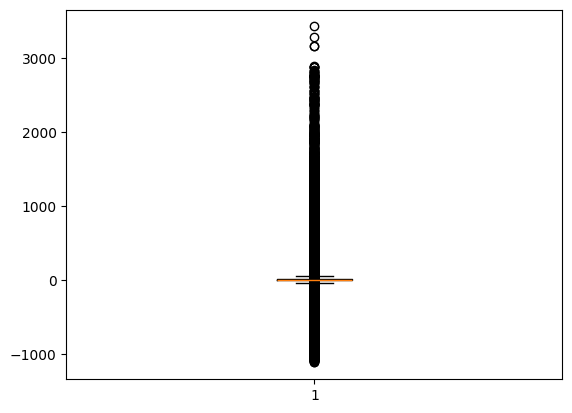

In [187]:
plt.boxplot(df_option_data['C_MID']-df_option_data['C_LAST'])
plt.show()

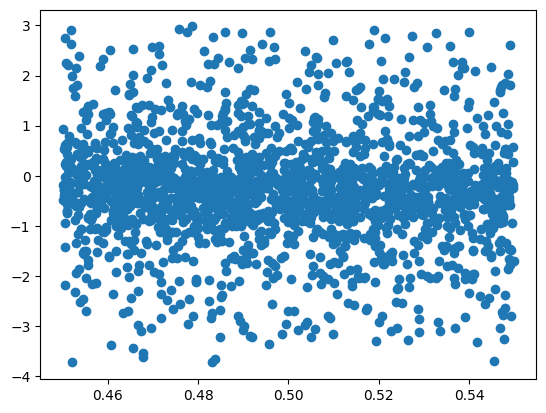

In [188]:
#i=len(df_quote_dates)-21*36
i=0
training_period = df_quote_dates.loc[i:i+21*36].values

plt.scatter(x=df_calls_diff.loc[training_period].xs('3M',level='Expiry_Bucket').xs(.5,level='BS_Delta_Bucket').C_DELTA_t1.to_numpy(),
            y=df_calls_diff.loc[training_period].xs('3M',level='Expiry_Bucket').xs(.5,level='BS_Delta_Bucket').y.to_numpy())

In [195]:
df_calls_diff

UNDERLYING_LAST_t1  DTE_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                               
2010-01-04    0.7             3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
              0.6             3M                        1132.99    45.0   
...                                                         ...     ...   
2022-12-29    0.5             12M                       3848.66   722.0   
                              12M                       3848.66   722.0   
              0.4             12M                       3848.66   722.0   
                              12M                       3848.66   722.0   
              0.6             12M                       3848.66  1814.0   

                                             C_DELTA_t1  C_VEGA_t1  C_IV_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                   
2010-01-04    0.7             3M                0.74893    1.27133  0.20731   
                              3M                0.73001    1.31920  0.20442   
                              3M                0.70983    1.36823  0.20162   
                              3M                0.68832    1.41197  0.19919   
              0.6             3M                0.64325    1.49082  0.19229   
...                                                 ...        ...      ...   
2022-12-29    0.5             12M               0.51798   20.56214  0.24363   
                              12M               0.45720   20.63773  0.23091   
              0.4             12M               0.42563   20.47217  0.22464   
                              12M               0.39408   20.16069  0.21919   
              0.6             12M               0.64088   27.57156  0.25299   

                                             C_LAST_t1  C_MID_t1     C_BS_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.7             3M                 63.67    63.400   65.509333   
                              3M                 59.50    59.405   61.526854   
                              3M                 55.15    55.605   57.636464   
                              3M                 50.70    51.795   53.883990   
              0.6             3M                 44.60    44.500   46.368799   
...                                                ...       ...         ...   
2022-12-29    0.5             12M               467.49   465.000  427.703255   
                              12M               371.30   369.000  333.330339   
              0.4             12M               323.60   325.100  290.592761   
                              12M               283.11   284.500  252.489113   
              0.6             12M               975.00   977.150  879.470669   

                                             C_VOLUME_t1  UNDERLYING_LAST_t0  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.7             3M                    10.0             1136.40   
                              3M                    14.0             1136.40   
                              3M                    19.0             1136.40   
                              3M                    13.0             1136.40   
              0.6             3M                    26.0             1136.40   
...                                                  ...                 ...   
2022-12-29    0.5             12M                   75.0             3839.81   
                              12M                  125.0             3839.81   
              0.4             12M                    1.0             3839.81   
                              12M                    1.0             3839.81   
              0.6             12M       

In [241]:
df_comp_data = pd.read_csv('2013-01-16options.csv')

df_comp_data = df_comp_data.loc[(df_comp_data.underlying == 'SPX') & (df_comp_data.volume > 0) & (df_comp_data.expiration > '2013-03-01')]
df_comp_data = df_comp_data[df_comp_data.strike == 1450]
df_comp_data = df_comp_data[df_comp_data.type == 'call']

In [242]:
df_comp_data.sort_values('expiration')

,contract,underlying,expiration,type,strike,style,bid,bid_size,ask,ask_size,volume,open_interest,quote_date,delta,gamma,theta,vega,implied_volatility
400428,SPX130316C01450000,SPX,2013-03-16,call,1450.0,E,41.3,NaN,41.9,NaN,21258,88036,2013-01-16,0.6657,0.0063,-68.4305,214.3058,0.0978
400626,SPXQ130328C01450000,SPX,2013-03-28,call,1450.0,E,44.9,NaN,46.7,NaN,2,2818,2013-01-16,0.6228,0.0046,-84.5829,245.5720,0.1286
400794,SPX130420C01450000,SPX,2013-04-20,call,1450.0,E,51.0,NaN,51.9,NaN,1995,13677,2013-01-16,0.6098,0.0039,-75.6463,285.7479,0.1308
400928,SPX130622C01450000,SPX,2013-06-22,call,1450.0,E,63.5,NaN,64.7,NaN,1345,31740,2013-01-16,0.5931,0.0030,-60.8637,373.9774,0.1338
401134,SPX130921C01450000,SPX,2013-09-21,call,1450.0,E,79.3,NaN,80.8,NaN,1000,13897,2013-01-16,0.5855,0.0023,-48.3268,472.4730,0.1318
401340,SPX131221C01450000,SPX,2013-12-21,call,1450.0,E,92.3,NaN,93.9,NaN,501,26996,2013-01-16,0.5826,0.0021,-41.2641,553.4666,0.1303
401428,SPXQ131231C01450000,SPX,2013-12-31,call,1450.0,E,93.0,NaN,95.8,NaN,12,273,2013-01-16,0.5809,0.0020,-42.6565,562.0803,0.1370
401534,SPX140118C01450000,SPX,2014-01-18,call,1450.0,E,95.8,NaN,97.5,NaN,10,3764,2013-01-16,0.5816,0.0020,-40.2652,576.1983,0.1322
401638,SPX140621C01450000,SPX,2014-06-21,call,1450.0,E,115.1,NaN,117.2,NaN,500,3321,2013-01-16,0.5796,0.0015,-37.3630,687.4501,0.1457


In [240]:
df_option_data[(df_option_data['QUOTE_DATE'] == '2013-01-16')&(df_option_data['STRIKE'] == 1450)]

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,C_MID,P_MID,C_BS
167881,1358370000,2013-01-16 16:00,2013-01-16,16.0,1472.59,2013-02-01,1359752400,16.00,0.70933,0.00939,1.07349,-0.31155,0.36607,0.12662,5.0,28.55,43 x 63,27.41,28.50,1450.0,6.40,6.89,123 x 46,6.20,-0.28810,0.00938,1.08211,-0.41641,-0.20030,0.11517,544.0,22.6,0.015,27.955,6.645,29.395099
167893,1358370000,2013-01-16 16:00,2013-01-16,16.0,1472.59,2013-02-08,1360357200,23.00,0.66892,0.00805,1.35079,-0.28699,0.49676,0.13084,3.0,31.20,48 x 78,30.20,31.11,1450.0,9.80,10.30,66 x 86,9.50,-0.33153,0.00803,1.36770,-0.39728,-0.32724,0.11943,89.0,22.6,0.015,30.655,10.050,32.642383
167920,1358370000,2013-01-16 16:00,2013-01-16,16.0,1472.59,2013-06-20,1371758400,154.96,0.54906,0.00281,3.74417,-0.14603,2.63380,0.15778,545.0,64.95,123 x 103,63.80,65.01,1450.0,53.80,55.01,185 x 155,53.46,-0.45561,0.00264,3.77992,-0.23057,-3.09817,0.15266,958.0,22.6,0.015,64.405,54.405,72.286237
167945,1358370000,2013-01-16 16:00,2013-01-16,16.0,1472.59,2014-01-16,1389906000,365.00,0.52839,0.00172,5.69579,-0.09860,5.42246,0.17354,10.0,97.25,155 x 24,96.40,97.90,1450.0,101.70,103.20,103 x 12,104.30,-0.47236,0.00158,5.74370,-0.17513,-7.99544,0.16912,2.0,22.6,0.015,97.150,102.450,113.431574
167951,1358370000,2013-01-16 16:00,2013-01-16,16.0,1472.59,2014-06-19,1403208000,518.96,0.52369,0.00139,6.72896,-0.08270,7.14952,0.18282,500.0,117.20,113 x 128,115.51,117.61,1450.0,133.79,135.79,103 x 15,135.00,-0.47332,0.00128,6.78184,-0.15993,-11.84837,0.17915,500.0,22.6,0.015,116.560,134.790,139.317754
167964,1358370000,2013-01-16 16:00,2013-01-16,16.0,1472.59,2014-12-18,1418936400,701.00,0.52077,0.00118,7.74205,-0.06979,9.04360,0.18721,100.0,141.00,129 x 22,132.60,135.80,1450.0,164.50,168.20,124 x 22,168.30,-0.47114,0.00101,7.79599,-0.14535,-16.54201,0.18407,5.0,22.6,0.015,134.200,166.350,163.422048


In [248]:
sum(df_option_data.C_VOLUME == 0)/len(df_option_data)

0.20013582542408279

In [255]:
sum(df_calls_diff.C_VOLUME_t0 == 0)

9432

In [259]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t0'].mean().unstack()

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_85178/802460118.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t0'].mean().unstack()


Expiry_Bucket,1M,3M,6M,9M,12M
BS_Delta_Bucket,,,,,
0.1,114.288485,91.501121,97.167287,85.419829,65.036600
0.2,115.777484,96.769829,103.239883,109.121509,90.144552
0.3,110.158525,90.080646,98.183457,106.875695,87.090463
0.4,97.627589,84.931450,95.700420,108.395934,95.022199
0.5,78.058664,86.724093,109.518472,133.915156,134.317320
0.6,50.284942,51.172342,66.235268,67.924860,78.081697
0.7,27.890609,26.142334,35.151163,37.860803,41.815860
0.8,20.927466,19.708539,27.894870,33.524590,19.704918
0.9,18.847655,25.411298,41.162500,30.408824,55.916667


In [ ]:
plt.boxplot(df_calls_diff.y.values)
plt.show()

In [ ]:
expiry_bucket = '6M'

fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.plot(df_params.xs(expiry_bucket,level=1).index,
         df_params.xs(expiry_bucket,level=1)[['a','b','c']]*[1,-1,1]
         )


ax2.plot(df_calls_diff.xs('6M', level='Expiry_Bucket').loc[df_params.index.get_level_values(0).min():].groupby('QUOTE_DATE_t1').C_IV_t0.mean().rolling(30).mean(),
         label='IV',
         color='r')

plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

### Assesing Gains

In [ ]:
def sse_bs(df_option_prices, expiry_bucket, delta_bucket):

    df = (df_option_prices
          .xs(delta_bucket,level='BS_Delta_Bucket')
          .xs(expiry_bucket, level='Expiry_Bucket'))
    
    epsilon_bs = df.delta_price - df.C_DELTA_t1*df.delta_S

    return sum(epsilon_bs**2)


def sse_mv(df_option_prices, df_params, expiry_bucket, delta_bucket):

    df = (df_option_prices
          .xs(delta_bucket,level='BS_Delta_Bucket')
          .xs(expiry_bucket, level='Expiry_Bucket'))
    
    a,b,c = df_params.loc[expiry_bucket,['a','b','c']]
    
    epsilon_bs = df.delta_price - df.C_DELTA_t1*df.delta_S
    epsilon_mv = epsilon_bs - (((df.C_VEGA_t1*100)*df.delta_S)/(np.sqrt(df.DTE_t1/360)*df.UNDERLYING_LAST_t1))*(a+b*df.C_DELTA_t1 + c*(df.C_DELTA_t1**2))


    return sum(epsilon_mv**2)


def gain_mv(df_option_prices, df_params, expiry_bucket, delta_bucket):

    _sse_bs = sse_bs(df_option_prices, expiry_bucket, delta_bucket)
    _sse_mv = sse_mv(df_option_prices, df_params, expiry_bucket, delta_bucket)

    return 1-_sse_mv/_sse_bs

In [90]:
df_quote_dates.loc[21*36+1:].values

array(['2013-03-26T00:00:00.000000000', '2013-03-27T00:00:00.000000000',
       '2013-03-28T00:00:00.000000000', ...,
       '2022-12-27T00:00:00.000000000', '2022-12-28T00:00:00.000000000',
       '2022-12-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [103]:
sorted(df_calls_diff.index.get_level_values(1).unique()) + ['Total']

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'Total']

In [189]:
lists = [
   df_quote_dates.loc[21*36+1:].values,
   sorted(df_calls_diff.index.get_level_values(1).unique()) + ['Total']
   ]


df_gain_mv = pd.DataFrame(index=pd.MultiIndex.from_tuples(itertools.product(*lists)),
                          columns=df_calls_diff.index.get_level_values(2).unique().categories)

df_gain_mv.index.names = ['start_testing','delta_bucket']
df_gain_mv['Total'] = np.nan

df_gain_mv.head(10)

1M   3M   6M   9M  12M  Total
start_testing delta_bucket                                
2013-03-11    0.1           NaN  NaN  NaN  NaN  NaN    NaN
              0.2           NaN  NaN  NaN  NaN  NaN    NaN
              0.3           NaN  NaN  NaN  NaN  NaN    NaN
              0.4           NaN  NaN  NaN  NaN  NaN    NaN
              0.5           NaN  NaN  NaN  NaN  NaN    NaN
              0.6           NaN  NaN  NaN  NaN  NaN    NaN
              0.7           NaN  NaN  NaN  NaN  NaN    NaN
              0.8           NaN  NaN  NaN  NaN  NaN    NaN
              0.9           NaN  NaN  NaN  NaN  NaN    NaN
              Total         NaN  NaN  NaN  NaN  NaN    NaN

In [ ]:
i=0
training_period = df_quote_dates.loc[i:i+21*36].values
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [ ]:
df_calls_diff.loc[testing_period[1:]].groupby(['BS_Delta_Bucket','Expiry_Bucket']).apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)).unstack()

In [ ]:
df_calls_diff.loc[testing_period[1:]].groupby(['BS_Delta_Bucket','Expiry_Bucket']).apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)).unstack()

In [ ]:
(0, len(df_quote_dates)-21*36)

In [97]:
df_epsilon_mv

Expiry_Bucket,12M,1M,3M,6M,9M,Total
BS_Delta_Bucket,,,,,,
0.1,1.823117,1.021425,0.082535,0.047033,NaN,2.974110
0.2,NaN,8.758234,10.435563,18.523621,9.760764,47.478182
0.3,NaN,33.670014,7.130109,6.532826,8.046129,55.379078
0.4,45.382522,146.868207,98.549023,9.420778,7.836338,308.056868
0.5,68.726097,163.137952,74.881068,40.713473,31.573732,379.032322
0.6,90.436395,325.018581,78.063747,62.398517,36.031809,591.949048
0.7,155.564610,117.895795,137.927220,36.117096,52.112984,499.617705
0.8,209.583573,124.360269,69.741859,0.691092,62.758400,467.135193
0.9,77.603511,21.234308,29.392910,NaN,25.230650,153.461380


In [102]:
df_epsilon_bs

Expiry_Bucket,12M,1M,3M,6M,9M,Total
BS_Delta_Bucket,,,,,,
0.1,5.363921,3.088826,0.484683,0.052856,NaN,8.990287
0.2,NaN,24.015098,25.504832,32.977279,30.774855,113.272065
0.3,NaN,47.150605,12.474602,18.696699,25.118212,103.440119
0.4,98.121022,207.834690,166.928461,15.426565,20.662120,508.972858
0.5,124.367802,193.575477,98.331153,79.643118,85.745167,581.662718
0.6,208.783858,403.249887,84.209052,114.963986,92.635816,903.842598
0.7,400.953342,152.728524,215.169899,86.211360,145.899308,1000.962433
0.8,596.946729,160.843034,115.272197,0.098768,181.375865,1054.536593
0.9,204.996052,28.491541,45.366217,NaN,65.894550,344.748360


In [190]:
for i in range(0, len(df_quote_dates)-21*36-20):
#for i in range(0, 1000):
    
        testing_period = df_quote_dates.loc[i+21*36: i+21*36+20].values

        df_loop = pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                           df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                           left_on = 'Expiry_Bucket',
                        right_on = 'expiry_bucket'
                        )

        df_loop['epsilon_bs'] = df_loop['delta_price'] - df_loop['C_DELTA_t1']*df_loop['delta_S']

        df_loop['epsilon_mv'] = df_loop['epsilon_bs'] - (df_loop['C_VEGA_t1']*100*df_loop['delta_S_perc']
                                                        *(df_loop['a']+df_loop['b']*df_loop['C_DELTA_t1']+df_loop['c']*(df_loop['C_DELTA_t1']**2))
                                                        /np.sqrt(df_loop['DTE_t1']/360))

        df_epsilon_bs = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                        observed=True)
                                        .apply(lambda x: sum((x.epsilon_bs)**2))
                                        .unstack())

        df_epsilon_bs['Total'] = (df_loop
                                        .groupby('BS_Delta_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_bs)**2)))


        df_epsilon_bs.loc['Total'] = (df_loop
                                        .groupby('Expiry_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_bs)**2)))

        df_epsilon_bs.loc['Total', 'Total'] = sum(df_loop['epsilon_bs']**2)

        df_epsilon_mv = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                        observed=True)
                                        .apply(lambda x: sum((x.epsilon_mv)**2))
                                        .unstack())

        df_epsilon_mv['Total'] = (df_loop
                                        .groupby('BS_Delta_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_mv)**2)))


        df_epsilon_mv.loc['Total'] = (df_loop
                                        .groupby('Expiry_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_mv)**2)))

        df_epsilon_mv.loc['Total', 'Total'] = sum(df_loop['epsilon_mv']**2)


        df_gain_mv.loc[testing_period[1]] = (1 - df_epsilon_mv/df_epsilon_bs).values

<Axes: xlabel='start_testing'>

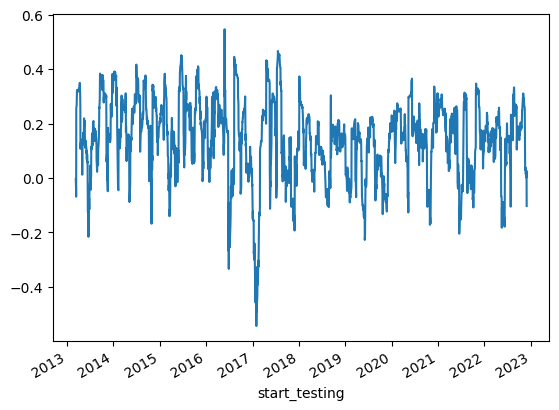

In [192]:
df_gain_mv['Total'].xs('Total', level='delta_bucket').plot()

In [132]:
df_gain_mv.loc['2022-10-11']

,1M,3M,6M,9M,12M,Total
delta_bucket,,,,,,
0.1,NaN,-1.156031,-1.365242,-20.699694,NaN,-1.298010
0.2,NaN,-1.129578,-1.264452,-1.401285,-1.621803,-1.276571
0.3,-0.550732,-0.951998,-1.104665,-1.152978,-0.845575,-1.055269
0.4,-0.344076,-0.909159,-1.062534,-1.068257,-0.623515,-0.909430
0.5,-0.226445,-0.789802,-0.953402,-1.030276,-0.589328,-0.788703
0.6,-0.093866,-0.630619,-0.80782,-77.585883,-0.536091,-16.120920
0.7,-0.032351,-0.470772,-0.69227,-0.786474,-0.434494,-0.543875
0.8,0.081317,-0.376625,-0.529981,-0.62562,-0.373825,-0.428725
0.9,0.204267,-0.161139,-0.101489,-0.026847,0.190741,-0.012099


<Axes: xlabel='start_testing'>

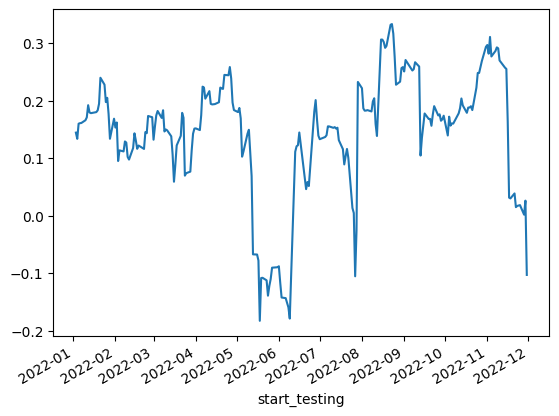

In [196]:
df_gain_mv['Total'].xs('Total', level='delta_bucket').loc['2022-01-01':].plot()

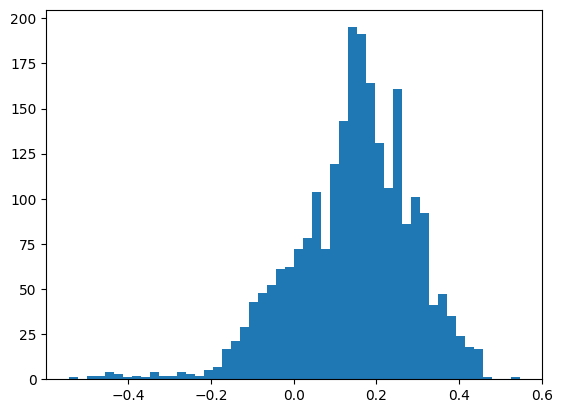

In [274]:
plt.hist(df_gain_mv['Total'].xs('Total', level='delta_bucket'), bins=50)
plt.show()

In [194]:
df_gain_mv.groupby('delta_bucket').mean()

,1M,3M,6M,9M,12M,Total
delta_bucket,,,,,,
0.1,0.046898,-0.020606,-18.240579,-1.794551,-6.976761,0.078254
0.2,-0.131746,0.03872,0.124218,-2.787857,-0.738143,0.099371
0.3,-0.784063,0.091309,0.083512,-0.874186,-0.124936,0.095829
0.4,-0.035745,0.106581,0.115593,0.013432,-0.59388,0.110190
0.5,0.11698,0.148973,0.152101,0.14079,0.10101,0.148754
0.6,-0.290272,0.14191,0.118053,0.110449,-0.051039,0.131598
0.7,0.100685,0.142526,0.143208,-0.327584,0.065883,0.150618
0.8,-0.514047,0.139436,0.192541,-2.508495,-0.869837,0.165159
0.9,-20.634359,0.03604,0.137369,-3.15326,-2.892448,0.159315


In [269]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack()

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_85178/672001989.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack()


Expiry_Bucket,1M,3M,6M,9M,12M
BS_Delta_Bucket,,,,,
0.1,110.105586,83.896803,85.453752,73.400420,50.760331
0.2,108.351388,85.706284,91.471026,96.651265,66.559303
0.3,101.538436,82.104693,88.291641,93.910293,67.623978
0.4,89.661326,74.337629,84.267226,91.403317,75.175899
0.5,85.494445,87.435717,100.754421,121.902519,115.801810
0.6,45.449839,44.628820,55.006412,59.780337,61.455030
0.7,24.665484,23.164119,33.095634,35.991343,30.762097
0.8,18.779481,18.206070,27.579482,31.297814,18.808197
0.9,18.219421,18.372824,26.885938,39.088235,36.215278


/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_85178/1061058021.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack().sum(1).plot(kind='bar')


<Axes: xlabel='BS_Delta_Bucket'>

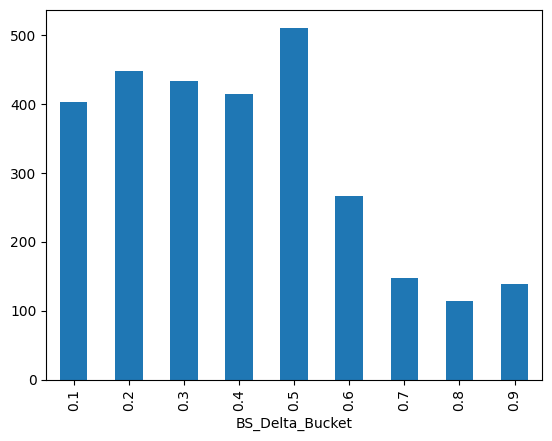

In [273]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack().sum(1).plot(kind='bar')

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_85178/2106703780.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack().sum(0).plot(kind='bar')


<Axes: xlabel='Expiry_Bucket'>

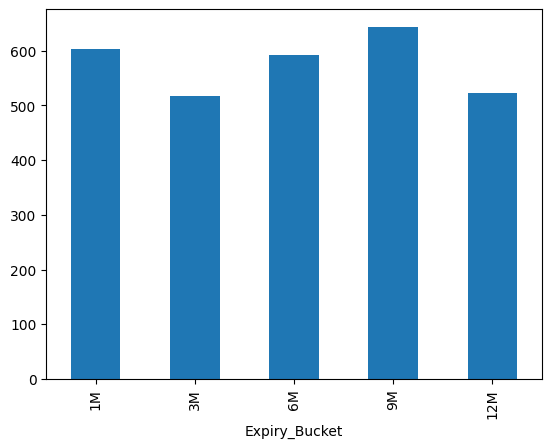

In [270]:
df_calls_diff.groupby(['BS_Delta_Bucket', 'Expiry_Bucket'])['C_VOLUME_t1'].mean().unstack().sum(0).plot(kind='bar')

In [268]:
df_calls_diff

UNDERLYING_LAST_t1  DTE_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                               
2010-01-04    0.7             3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
                              3M                        1132.99    45.0   
              0.6             3M                        1132.99    45.0   
...                                                         ...     ...   
2022-12-29    0.5             12M                       3848.66   722.0   
                              12M                       3848.66   722.0   
              0.4             12M                       3848.66   722.0   
                              12M                       3848.66   722.0   
              0.6             12M                       3848.66  1814.0   

                                             C_DELTA_t1  C_VEGA_t1  C_IV_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                   
2010-01-04    0.7             3M                0.74893    1.27133  0.20731   
                              3M                0.73001    1.31920  0.20442   
                              3M                0.70983    1.36823  0.20162   
                              3M                0.68832    1.41197  0.19919   
              0.6             3M                0.64325    1.49082  0.19229   
...                                                 ...        ...      ...   
2022-12-29    0.5             12M               0.51798   20.56214  0.24363   
                              12M               0.45720   20.63773  0.23091   
              0.4             12M               0.42563   20.47217  0.22464   
                              12M               0.39408   20.16069  0.21919   
              0.6             12M               0.64088   27.57156  0.25299   

                                             C_LAST_t1  C_MID_t1     C_BS_t1  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.7             3M                 63.67    63.400   65.509333   
                              3M                 59.50    59.405   61.526854   
                              3M                 55.15    55.605   57.636464   
                              3M                 50.70    51.795   53.883990   
              0.6             3M                 44.60    44.500   46.368799   
...                                                ...       ...         ...   
2022-12-29    0.5             12M               467.49   465.000  427.703255   
                              12M               371.30   369.000  333.330339   
              0.4             12M               323.60   325.100  290.592761   
                              12M               283.11   284.500  252.489113   
              0.6             12M               975.00   977.150  879.470669   

                                             C_VOLUME_t1  UNDERLYING_LAST_t0  \
QUOTE_DATE_t1 BS_Delta_Bucket Expiry_Bucket                                    
2010-01-04    0.7             3M                    10.0             1136.40   
                              3M                    14.0             1136.40   
                              3M                    19.0             1136.40   
                              3M                    13.0             1136.40   
              0.6             3M                    26.0             1136.40   
...                                                  ...                 ...   
2022-12-29    0.5             12M                   75.0             3839.81   
                              12M                  125.0             3839.81   
              0.4             12M                    1.0             3839.81   
                              12M                    1.0             3839.81   
              0.6             12M       

In [133]:
df_gain_mv['Total'].xs('Total', level='delta_bucket')

start_testing
2013-03-26    0.455022
2013-03-27    0.451857
2013-03-28    0.454904
2013-04-01    0.459156
2013-04-02    0.458344
                ...   
2022-12-22         NaN
2022-12-23         NaN
2022-12-27         NaN
2022-12-28         NaN
2022-12-29         NaN
Name: Total, Length: 2373, dtype: float64

In [27]:
(df_calls_diff.loc[testing_period[1:]]
                        .groupby('Expiry_Bucket',
                                observed=True)
                                .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)))

Expiry_Bucket
1M     1220.977684
3M      763.741096
6M      348.070631
9M      648.105893
12M    1639.532726
dtype: float64

In [45]:
testing_period[1:]

array(['2013-04-09T00:00:00.000000000', '2013-04-10T00:00:00.000000000',
       '2013-04-11T00:00:00.000000000', '2013-04-12T00:00:00.000000000',
       '2013-04-15T00:00:00.000000000', '2013-04-16T00:00:00.000000000',
       '2013-04-17T00:00:00.000000000', '2013-04-18T00:00:00.000000000',
       '2013-04-19T00:00:00.000000000', '2013-04-22T00:00:00.000000000',
       '2013-04-23T00:00:00.000000000', '2013-04-24T00:00:00.000000000',
       '2013-04-25T00:00:00.000000000', '2013-04-26T00:00:00.000000000',
       '2013-04-29T00:00:00.000000000', '2013-04-30T00:00:00.000000000',
       '2013-05-01T00:00:00.000000000', '2013-05-02T00:00:00.000000000',
       '2013-05-03T00:00:00.000000000', '2013-05-06T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [46]:
testing_period[0]

numpy.datetime64('2013-04-08T00:00:00.000000000')

In [47]:
df_params

a         b         c start_testing  \
end_testing expiry_bucket                                               
2013-03-25  1M            -0.228508  0.535961 -0.452283    2010-01-04   
            3M            -0.232177  0.462139  -0.46664    2010-01-04   
            6M            -0.258256   0.55594 -0.600934    2010-01-04   
            9M            -0.280989  0.600971 -0.721987    2010-01-04   
            12M           -0.277399  0.641813  -0.82839    2010-01-04   
...                             ...       ...       ...           ...   
2022-12-29  1M            -0.138054  0.226451 -0.213137    2019-11-22   
            3M            -0.141861  0.259235 -0.299518    2019-11-22   
            6M            -0.154429  0.325992 -0.371271    2019-11-22   
            9M            -0.198123  0.626323 -0.686782    2019-11-22   
            12M           -0.231518  0.808532 -0.850201    2019-11-22   

                            minus_b  
end_testing expiry_bucket            
2013-03-25  1M            -0.535961  
            3M            -0.462139  
            6M             -0.55594  
            9M            -0.600971  
            12M           -0.641813  
...                             ...  
2022-12-29  1M            -0.226451  
            3M            -0.259235  
            6M            -0.325992  
            9M            -0.626323  
            12M           -0.808532  

[11870 rows x 5 columns]

In [35]:
df_epsilon_bs = (df_calls_diff.loc[testing_period[1:]]
                .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                        observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2))
                        .unstack())

df_epsilon_bs['Total'] = (df_calls_diff.loc[testing_period[1:]]
                            .groupby('BS_Delta_Bucket',
                                    observed=True)
                                    .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)))

In [36]:
df_epsilon_bs.loc['Total'] = (df_calls_diff.loc[testing_period[1:]]
                        .groupby('Expiry_Bucket',
                                observed=True)
                                .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)))

In [43]:
df_calls_diff.loc[testing_period[1:]].apply(lambda x: (x.delta_price-x.C_DELTA_t1*x.delta_S)**2,axis=1).sum()

4620.428030049324

In [28]:
(pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )
                                  .groupby(['Expiry_Bucket'],
                                           observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S
                                                -(x.C_VEGA_t1*100)*x.delta_S_perc*(x.a + x.b*x.C_DELTA_t1 + x.c*(x.C_DELTA_t1**2))/np.sqrt(x.DTE_t1/360)
                                                )**2)))

Expiry_Bucket
12M    649.119825
1M     941.964786
3M     506.204035
6M     174.444434
9M     233.350806
dtype: float64

In [ ]:
testing_period

In [ ]:
pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )

In [ ]:
plt.hist((pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )
                                  .groupby(['BS_Delta_Bucket'],
                                           observed=True)
                        .apply(lambda x: (x.delta_price-x.C_DELTA_t1*x.delta_S
                                                -(x.C_VEGA_t1*100)*x.delta_S_perc*(x.a + x.b*x.C_DELTA_t1 + x.c*(x.C_DELTA_t1**2))/np.sqrt(x.DTE_t1/360)))),bins=30)

In [ ]:
plt.hist((pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                                  df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                                  left_on = 'Expiry_Bucket',
                                  right_on = 'expiry_bucket'
                                  )
                                  .groupby(['BS_Delta_Bucket'],
                                           observed=True)
                        .apply(lambda x: (x.delta_price-x.C_DELTA_t1*x.delta_S
                                                ))),bins=30)

In [ ]:
df_calls_diff.loc[testing_period[1:]]

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_bs

In [ ]:
df_gain_mv

In [ ]:
df_gain_mv.loc[:'2022-01-01'].groupby('delta_bucket')['1M'].mean()

In [ ]:
df_gain_mv['Total'].xs(.6,level='delta_bucket').loc[:'2022-01-01'].head(100).plot()

In [ ]:
df_params.xs('6M', level='expiry_bucket')[['a','minus_b','c']].head(90).plot()

In [ ]:
df_epsilon_mv['Total'] = df_epsilon_mv.sum(1)

In [ ]:
df_epsilon_mv

In [ ]:
df_gain_mv

In [ ]:
len(df_quote_dates)-21*36

In [ ]:
testing_period

In [ ]:
df_gain_mv

In [ ]:
df_gain_mv.fillna(0).groupby('delta_bucket')[df_gain_mv.columns].mean()

In [ ]:
df_gain_mv.head(10)

In [ ]:
(df_calls_diff.loc[testing_period[1:]]
 .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
          observed=True)
 .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2)).unstack())

In [ ]:
df_params.loc[testing_period[0],['a','b','c']]

In [ ]:
sse_bs(df_calls_diff.loc[testing_period[1:]],'6M',.5)

In [ ]:
sse_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],'6M',.5)

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],'6M',.5)

In [ ]:
testing_period[1:]

In [ ]:
lists = [
   df_quote_dates.loc[21*36:].values,
   df_calls_diff.index.get_level_values(2).unique().categories
   
]

df_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_params.index.names = ['end_testing', 'expiry_bucket']

df_params['start_testing'] = df_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_quote_dates.loc[21*36:].values, df_quote_dates.loc[:].values)})

In [ ]:
df_calls_diff.index.get_level_values(1).unique()

In [ ]:
i=0
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
       df_params.loc[testing_period[0]],
       '6M',
       .5)

In [ ]:
df_gain_mv.loc[testing_period[1]].columns

In [ ]:
len(df_quote_dates)-(21*36+30)

In [ ]:
i = 1000
training_period = df_quote_dates.loc[i:i+21*36].values
testing_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            '6M',
                                                            .5)

In [ ]:
df_gain_mv.xs(.9,level='delta_bucket')['3M'].loc[:'2022-01-01'].mean()

In [ ]:
df_gain_mv.xs(.2,level='delta_bucket')['6M'].loc[:'2022-01-01'].to_frame().min()

In [ ]:
df_gain_mv.loc['2013-10-29']

In [ ]:
df_gain_mv.loc[:'2022-01-01'].groupby('delta_bucket').mean()*100

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_mv.sum(1)

In [ ]:
1-df_epsilon_mv.sum(1)/df_epsilon_bs.sum(1)

In [ ]:
df_quote_dates.loc[933]

In [ ]:
testing_period = (df_quote_dates[(df_quote_dates > '2013-10-29')
               &(df_quote_dates < '2013-12-13')]).to_numpy()

In [ ]:
testing_period

In [ ]:
testing_period[1:]

In [ ]:
df_calls_diff.loc[testing_period[1:]].xs('6M', level='Expiry_Bucket').xs(.2, level='BS_Delta_Bucket')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
testing_period = (df_quote_dates[(df_quote_dates > '2013-10-29')
               &(df_quote_dates < '2013-12-13')]).to_numpy()

df_epsilon_bs = (df_calls_diff.loc[testing_period[1:]]
                .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                        observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2))
                        .unstack())

df_epsilon_mv = (pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                            df_params.loc[testing_period[0],['a','b','c']].reset_index(),
                            left_on = 'Expiry_Bucket',
                            right_on = 'expiry_bucket'
                            )
                            .groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                    observed=True)
                .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S
                                        -x.C_VEGA_t1*100*x.delta_S_perc*(x.a + x.b*x.C_DELTA_t1 + x.c*(x.C_DELTA_t1**2))/np.sqrt(x.DTE_t1/360)
                                        )**2))
                .unstack())

df_epsilon_mv = df_epsilon_mv.loc[df_gain_mv.loc[testing_period[1]].index
                                ,df_gain_mv.loc[testing_period[1]].columns]

df_epsilon_bs = df_epsilon_bs.loc[df_gain_mv.loc[testing_period[1]].index
                                ,df_gain_mv.loc[testing_period[1]].columns]


df_gain_mv.loc[testing_period[1]] = (1 - df_epsilon_mv/df_epsilon_bs).values

In [ ]:
df_gain_mv.loc[testing_period[1]]

In [ ]:
(df_calls_diff.loc[testing_period[1:]]
                .groupby(['BS_Delta_Bucket', 'Expiry_Bucket'],
                        observed=True)
                        .apply(lambda x: sum((x.delta_price-x.C_DELTA_t1*x.delta_S)**2))
                        .unstack())

In [ ]:
df_epsilon_mv

In [ ]:
df_epsilon_bs

In [ ]:
(1 - df_epsilon_mv/df_epsilon_bs)

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[3:]],
                                                            df_params.loc[testing_period[4]],
                                                            '6M',
                                                            .2)

In [ ]:
gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            expiry,
                                                            delta)

In [ ]:
for delta in df_gain_mv.loc[testing_period[1]].index:

    for expiry in df_gain_mv.loc[testing_period[1]].columns:


        try:
            df_gain_mv.loc[testing_period[1], delta][expiry] = gain_mv(df_calls_diff.loc[testing_period[1:]],
                                                            df_params.loc[testing_period[0]],
                                                            expiry,
                                                            delta)
        except:
            
            pass

In [ ]:
3000*2/60

In [ ]:
df_gain_mv.loc[testing_period[1], delta][expiry]

In [ ]:
df_gain_mv.head(10)

In [ ]:
1-45.86514506071337/86.80437565410338

In [ ]:
def sse_helio(params, df_option_prices, expiry_bucket):

    a = params[0]
    b = params[1]
    c = params[2]

    df = df_option_prices.xs(expiry_bucket,level='Expiry_Bucket')
    df = df.groupby(['BS_Delta_Bucket'])[['delta_S', 'delta_price', 'UNDERLYING_LAST_t1', 'C_VEGA_t1', 'DTE_t1']].mean()

    print(len(df))

    epsilon_bs = df['delta_price'] - df.index*df['delta_S']
    epsilon_mv = epsilon_bs - (df['C_VEGA_t1']*100*df['delta_S']/(df['UNDERLYING_LAST_t1']*np.sqrt(df.DTE_t1/360)))*(a+b*df.index+c*(df.index**2))

    return sum(epsilon_mv**2)


for i in range(0, len(df_quote_dates)-21*36):

    testing_period = df_quote_dates.loc[i:i+21*36].values
    training_period = df_quote_dates.loc[i+21*36:i+21*36+30].values

    for expiry in df_params.loc[testing_period[-1]].index:

        result = minimize(fun=sse_helio,
            x0=np.array([0, 0, 0]),
            args=(df_calls_diff.loc[testing_period], expiry),
            method='SLSQP',
            )

        df_params.loc[testing_period[-1]].loc[expiry,['a','b','c']] = result.x

    print(testing_period[-1])



In [ ]:
df_params

In [ ]:
df_calls_diff.loc['2018-4-01':'2019-6-01']

In [ ]:
plt.plot(df_params.xs('3M',level=1)[['a','b','c']])
plt.show()

In [ ]:
df_params.loc[testing_period[-1]].loc['3M'] = result.x

In [ ]:
def sse_mv(params, df_option_prices, expiry_bucket):

    a = params[0]
    b = params[1]
    c = params[2]

    df = df_option_prices.xs(expiry_bucket,level='Expiry_Bucket')

    epsilon_bs = df['delta_price_perc'] - df['C_DELTA_t1']*df['delta_S_perc']
    epsilon_mv = epsilon_bs - (df['C_VEGA_t1']*100*df['delta_S_perc']/(np.sqrt(df.DTE_t1/360)))*(a+b*df['C_DELTA_t1']+c*(df['C_DELTA_t1']**2))

    return sum(epsilon_mv**2)


result = minimize(fun=sse_mv,
         x0=np.array([0, 0, 0]),
         args=(df_calls_diff.loc[testing_period], '3M'),
         method='SLSQP',
         )

print(result)

In [ ]:
a,b,c = result.x

x = df_calls_diff.loc[df_calls_diff.QUOTE_DATE_t0 == df_calls_diff.QUOTE_DATE_t0.max()].xs('6M',level='Expiry_Bucket').C_DELTA_t0
y = df_calls_diff.loc[df_calls_diff.QUOTE_DATE_t0 == df_calls_diff.QUOTE_DATE_t0.max()].xs('6M',level='Expiry_Bucket').apply(lambda row: row.C_VEGA_t0*100/(row.UNDERLYING_LAST_t0*np.sqrt(row.DTE_t0/360))*(a+b*row.C_DELTA_t0+c*(row.C_DELTA_t0**2)) ,axis=1)
plt.scatter(x=x,y=y)

In [ ]:
a,b,c = result.x

In [ ]:
x = [a+b*x+c*(x**2) for x in df_calls_diff.C_DELTA_t1]*df_calls_diff.delta_S_perc/(np.sqrt(df_calls_diff.DTE_t1/360))
y = df_calls_diff['C_IV_t0'] - df_calls_diff['C_IV_t1']


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data,c='black')

plt.show()

print(f"""Linear Regression - Change in Implied vs Normalized Return: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
plt.boxplot((df_helio['C_IV_t0']-df_helio['C_IV_t1']))
plt.show()

In [ ]:
#Parse data for CALLS

df_calls_data = df_option_data.drop(['P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 
                                     'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV','P_VOLUME'], axis=1)

df_calls_data = df_calls_data[(df_calls_data.C_DELTA < .95)&(df_calls_data.C_DELTA > .05)]
df_calls_data['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls_data.C_DELTA]

df_calls_data['Expiry_Bucket'] = pd.cut(df_calls_data.DTE,[14,30,91, 182,365,2000],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

#df_calls_data = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket'])

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df_calls_data.set_index(['EXPIRE_UNIX'])

In [ ]:
df_foo = df_calls_data.set_index(['BS_Delta_Bucket','Expiry_Bucket']).loc[(.5,'6M')]

df_foo = df_foo.groupby('QUOTE_DATE')[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE','C_MID','C_BS']].mean()

df_foo['Delta_S'] = df_foo['UNDERLYING_LAST'].diff()/df_foo['UNDERLYING_LAST']
df_foo['Delta_IV'] = df_foo['C_IV'].diff()

df_foo = df_foo.dropna()

x = df_foo['Delta_IV']
y = df_foo['Delta_S']

slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Asset Price vs Change in Implied Vol: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

x = (df_foo['UNDERLYING_LAST'].diff()*df_foo['C_DELTA']).dropna()
y = df_foo['C_BS'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
pd.to_datetime('2010-01-08')-pd.to_datetime('2010-04-15')

In [ ]:
df_calls_data.iloc[1000]


In [ ]:
black_scholes(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
              K=df_calls_data.iloc[1000].STRIKE,
              sigma=df_calls_data.iloc[1000].C_IV,
              T=df_calls_data.iloc[1000].DTE/360,
              r=-0.01)

In [ ]:
bs_delta(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
         K=df_calls_data.iloc[1000].STRIKE,
         sigma=df_calls_data.iloc[1000].C_IV,
         T=df_calls_data.iloc[1000].DTE/360,
         r=-0.01)

In [ ]:
bs_vega(S=df_calls_data.iloc[1000].UNDERLYING_LAST,
              K=df_calls_data.iloc[1000].STRIKE,
              sigma=df_calls_data.iloc[1000].C_IV,
              T=df_calls_data.iloc[1000].DTE/360,
              r=-0.01)

In [ ]:
df_calls_data = df_calls_data.groupby(['Expiry_Bucket','QUOTE_DATE','BS_Delta_Bucket'])[['UNDERLYING_LAST', 'C_IV', 'C_MID', 'C_DELTA', 'C_VEGA', 'DTE']].mean().copy()
df_calls_data = df_calls_data.dropna()

In [ ]:
df_calls_data

In [ ]:
df_calls_data.index.get_level_values(0).unique().to_list()

In [ ]:
def sse(params):

    total_sse = 0.0

    a = params[0]
    b = params[1]
    c = params[2]

    for expiry in df_calls_data.index.get_level_values(0).unique().to_list():

        delta_f = df_calls_data.xs(expiry).groupby(level=1)['C_MID'].diff()
        delta_s = df_calls_data.xs(expiry).groupby(level=1)['UNDERLYING_LAST'].diff()
        delta_bs = df_calls_data.xs(expiry).groupby(level=1).diff().index.get_level_values(1)
        vega_bs = df_calls_data.xs(expiry)['C_VEGA']*100
        dte = df_calls_data.xs(expiry)['DTE']/360
        underlying = df_calls_data.xs(expiry)['UNDERLYING_LAST']
        
        error_bs = delta_f - delta_bs*delta_s
        error_mv = error_bs - (vega_bs*delta_s/(np.sqrt(dte)*underlying))*(a + b*delta_bs + c*(delta_bs**2))
        error_mv = error_mv.dropna()
    
        total_sse += sum(error_mv**2)
    
    return total_sse


In [ ]:
sse(np.array([0,0,0]))

In [ ]:
df_foo2 = df_calls_data.xs('6M', level=1)

df_foo2 = df_foo2.groupby(['BS_Delta_Bucket','QUOTE_DATE'])[['UNDERLYING_LAST', 'C_IV', 'C_LAST', 'C_DELTA', 'C_VEGA', 'DTE']].mean()

list_slopes = []

for delta_bucket in df_foo2.index.get_level_values(0).unique():

    df_loop = df_foo2.loc[delta_bucket]
    df_loop['Delta_S'] = df_loop['UNDERLYING_LAST'].diff()/df_loop['UNDERLYING_LAST']
    
    df_loop['Delta_IV'] = df_loop['C_IV'].diff()

    df_loop = df_loop.dropna()

    x = df_loop['Delta_IV']
    y = df_loop['Delta_S']

    slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
    fitted_data = list(map(fitted_line, x))

    # plt.scatter(x = df_loop['Delta_IV'],
    #             y = df_loop['Delta_S'])

    # plt.plot(x, fitted_data)

    # plt.show()
    list_slopes.append(slope)
    # print(f"""Linear Regression - Log Std Deviation of Prices vs Log Simulations: \n
    #     Slope:{slope}\n
    #     Intercept:{intercept}\n  
    #     R²: {r**2}""")
    
    # print(delta_bucket)


In [ ]:
df_foo2 = df_foo2.reset_index().sort_values(['QUOTE_DATE','BS_Delta_Bucket']).set_index(['QUOTE_DATE','BS_Delta_Bucket'])
quote_dates = df_foo2.index.get_level_values(0).unique()

In [ ]:
def epsilon_mv(df_t0, df_t1, a, b, c):

    available_deltas = list(set(df_t0.index).intersection(df_t1.index))
    df_t0 = df_t0.loc[available_deltas]
    df_t1 = df_t1.loc[available_deltas]

    epsilon_bs = (df_t0.C_LAST-df_t1.C_LAST) - df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)
    epsilon_mv = epsilon_bs - ((df_t1.C_VEGA*100*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))
    return epsilon_mv

In [ ]:
epsilon_mv_total = []

for i in range(len(quote_dates)-1):

    epsilon_mv_total.append(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=0,b=0,c=0).to_list())

SSE = sum([sum(np.array(error)**2) for error in epsilon_mv_total])
print(np.sqrt(SSE))

In [ ]:
quote_dates[i]

In [ ]:
np.sqrt(sum([sum(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=0,b=0,c=0)**2) for i in range(len(quote_dates)-1)]))

In [ ]:
    
def sse_mv(params):

    a = params[0]
    b = params[1]
    c= params[2]

    epsilon_mv_total = []

    for i in range(len(quote_dates)-1):

        epsilon_mv_total.append(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=a,b=b,c=c).to_list())

    return sum([sum(np.array(error)**2) for error in epsilon_mv_total])

In [ ]:
result = minimize(fun=sse,
         x0=np.array([0, 0, 0]),
         method='Nelder-Mead',
         )

print(result)

In [ ]:
np.sqrt(sse_mv(result.x))

In [ ]:
df_calls_data

In [ ]:
a,b,c = result.x

y = df_calls_data.xs('2012-12-31',level=1).xs('9M', level=0)
plt.scatter(x=y.index,y=y.index + y.C_VEGA*10/(y.UNDERLYING_LAST*np.sqrt(y.DTE/360))*(a+b*y.index+c*(y.index**2)))

In [ ]:
(y.C_VEGA/(y.UNDERLYING_LAST*np.sqrt(y.DTE/360))*(a+b*y.index+c*(y.index**2)))

In [ ]:
c*(y.index**2)

In [ ]:
y = df_option_data.iloc[28364]
print(y.head(20))
print(black_scholes(S=y.UNDERLYING_LAST,K=y.STRIKE,sigma=y.C_IV,T=y.DTE/360,r=0.0))
bs_delta(S=y.UNDERLYING_LAST,K=y.STRIKE,sigma=y.C_IV,T=y.DTE/360,r=0)

In [ ]:
np.sqrt(sse_mv(np.array([-0.2,.4,-.5])))

In [ ]:
np.sqrt(sse(np.array([-3.090e+00, 1.269e+01, -1.925e+01])))

In [ ]:
# for prettier numpy prints
np.set_printoptions(precision = 6)

In [ ]:
sse(np.array([0,0,0]))

In [ ]:
np.sqrt(sse(result.x))

In [ ]:
call

In [ ]:
result.x

In [ ]:
np.sqrt(sse([0,0,0]))

In [ ]:
df_calls_data

In [ ]:
[i/np.sqrt(360) for i in [-3.400e+00 ,1.478e+01, -2.341e+01]]

In [ ]:
quote_dates

In [ ]:
df_foo2.loc[quote_dates[i-1]].index

In [ ]:
list(set(df_foo2.loc[quote_dates[i-1]].index).intersection(df_foo2.loc[quote_dates[i]].index))

In [ ]:
sum(epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=-.0,b=0,c=0)**2)

In [ ]:
epsilon_mv(df_foo2.loc[quote_dates[i]], df_foo2.loc[quote_dates[i-1]], a=-.05,b=0,c=-.6).to_list()

In [ ]:
quote_dates[i-1]

In [ ]:
df_t0

In [ ]:
a,b,c=0,0,0
i=30
df_t0 = df_foo2.loc[quote_dates[i]]
df_t1 = df_foo2.loc[quote_dates[i-1]]

available_deltas = list(set(df_t0.index).intersection(df_t1.index))
df_t0 = df_t0.loc[available_deltas]
df_t1 = df_t1.loc[available_deltas]

epsilon_bs = (df_t0.C_LAST-df_t1.C_LAST) - df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)
epsilon_mv = epsilon_bs - ((df_t1.C_VEGA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))

In [ ]:
(df_t0.C_LAST-df_t1.C_LAST)

In [ ]:
df_t1.C_DELTA*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST)

In [ ]:
sum(epsilon_bs**2)

In [ ]:
a=.0
((df_t1.C_VEGA*100*(df_t0.UNDERLYING_LAST - df_t1.UNDERLYING_LAST))/(np.sqrt(df_t1.DTE/360)*df_t1.UNDERLYING_LAST))*(a+b*df_t1.index+c*(df_t1.index**2))

In [ ]:
df_t0.UNDERLYING_LAST

In [ ]:
df_foo2.loc[quote_dates[i-1]]

In [ ]:
df_foo2.loc[quote_dates[i],['C_LAST', 'C_BID', 'C_ASK']]

In [ ]:
plt.plot((df_foo2.loc['2010-01-05'].C_LAST-df_foo2.loc['2010-01-06'].C_LAST)-(df_foo2.loc['2010-01-05'].UNDERLYING_LAST-df_foo2.loc['2010-01-06'].UNDERLYING_LAST)*df_foo2.loc['2010-01-05'].C_DELTA)

In [ ]:
df_foo2.index.get_level_values(0).unique()

In [ ]:
list_slopes = np.sqrt(df_foo2.groupby('BS_Delta_Bucket')['DTE'].mean().values/360)*list_slopes

x = df_foo2.index.get_level_values(0).unique()
y = list_slopes

model = np.poly1d(np.polyfit(x, y, 2))

#add fitted polynomial line to scatterplot
plt.scatter(x, y)
plt.plot(x, model(x))

print(model)
plt.show()



In [ ]:
for i in df_foo2.index.get_level_values(0).unique():

    df_foo2.loc[i]

In [ ]:
df_foo2.loc[.5].C_LAST.diff().plot()

In [ ]:
plt.plot(df_foo2.loc[i].C_DELTA)

In [ ]:
i=.5
plt.plot(df_foo2.loc[i].UNDERLYING_LAST.diff()*df_foo2.loc[i].C_DELTA)
plt.plot(df_foo2.loc[i].C_LAST.diff())

In [ ]:
df_foo2.loc[i].C_LAST.diff()

In [ ]:
y

#### $ \Delta f - \delta_{bs}\Delta S = \frac{\nu_{bs}}{\sqrt{T}}\frac{\Delta S}{S}(a+b\delta_{bs}+\delta^{2}_{bs}) $

In [ ]:
df_foo2.loc[i,'UNDERLYING_LAST'].diff()*df_foo2.loc[i,'C_VEGA']/(np.sqrt(df_foo2.loc[i,'DTE'])*df_foo2.loc[i,'UNDERLYING_LAST'])

In [ ]:
x = (df_foo2.loc[i]['UNDERLYING_LAST'].diff()*df_foo2.loc[i]['C_DELTA']).dropna()
y = df_foo2.loc[i]['C_LAST'].diff().dropna()


slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)

def fitted_line(x):
  return slope * x + intercept

fitted_data = list(map(fitted_line, x))

plt.scatter(x = x,
            y = y)

plt.plot(x, fitted_data)

plt.show()

print(f"""Linear Regression - Change in Option Price vs PnL Delta: \n
      Slope:{slope}\n
      Intercept:{intercept}\n  
      R²: {r**2}""")

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x-y).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)

In [ ]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

data = (x).values
bins = 30

bins = np.histogram(data, 
                    bins=30)[1]

bins = [float(x) for x in bins]


fig, ax = plt.subplots(figsize=(25,16))

sns.histplot(data,stat='density',
                bins=30,
                ax=ax)

sns.lineplot(ax=ax,
             x=bins,
             y=gaussian(data=data,
                        bins=bins),
            color='red')


textstr = '\n'.join((
    r'$\mu=%.2f$' % (np.mean(data), ),
    r'$\mathrm{median}=%.2f$' % (np.median(data), ),
    r'$\sigma=%.2f$' % (np.std(data), ),
    r'$\frac{\sigma}{\mu}=%.2f$'% (np.std(data)*100/np.mean(data), )+'%'))

ax.text(0.1, 0.95, textstr, 
            horizontalalignment='center', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            bbox=props)